In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, Conv2D, MaxPooling2D, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import DenseNet121, VGG16, ResNet50
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
image_size = 64
batch_size = 32

In [4]:
def split(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train = ds.take(train_size)
    val = ds.skip(train_size).take(val_size)
    test = ds.skip(train_size).skip(val_size)
    return train, val, test

In [5]:
def predict(model, img, class_names):
    img_array = tf.keras.preprocessing.image.img_to_array(img)  # Convert image to array
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension

    predictions = model.predict(img_array)  # Make prediction

    predicted_class = class_names[np.argmax(predictions[0])]  # Get class name
    confidence = round(100 * (np.max(predictions[0])), 2)  # Confidence score

    return predicted_class, confidence  # Return class and confidence


In [6]:
images = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/eurosat-dataset/EuroSAT",
    shuffle = True, 
    image_size = (image_size, image_size),
    batch_size = batch_size
)

Found 27000 files belonging to 10 classes.


# Data Exploration

In [7]:
images.class_names

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

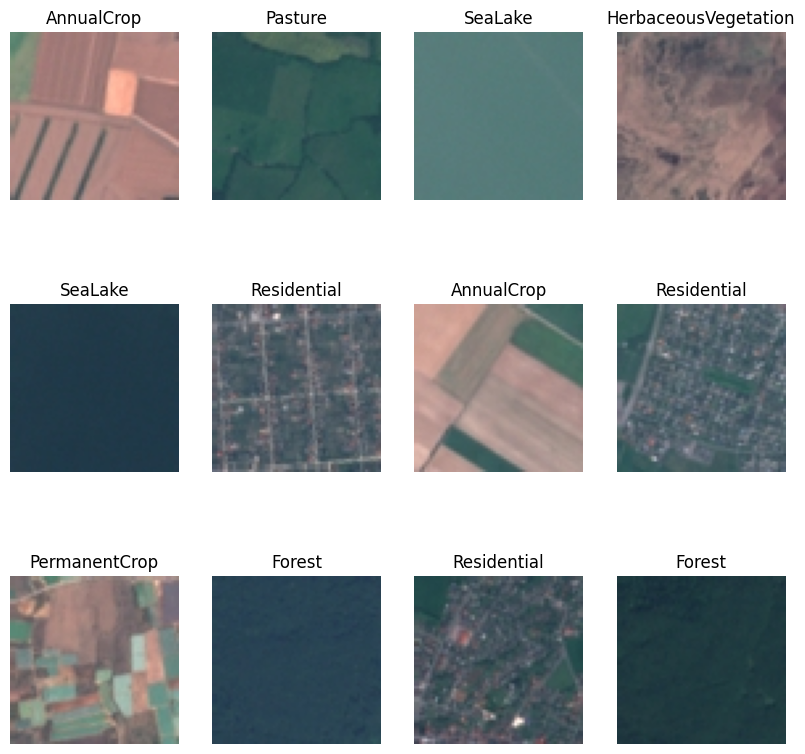

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in images.take(1):
    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(images.class_names[label_batch[i]])
        plt.axis("off")

# Data Splitting 

In [9]:
train, val, test = split(images)

# Data Preprocessing 

In [10]:
resize_rescale = tf.keras.Sequential([
    layers.Resizing(image_size, image_size),  # Ensure all images are 64x64
    layers.Rescaling(1.0 / 255),  # Normalize pixel values to [0,1]
])

In [11]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),  # Flip images randomly
    layers.RandomRotation(0.2),  # Rotate images by ±20% of 360°
    layers.RandomZoom(0.2),  # Random zooming
    layers.RandomContrast(0.2),  # Adjust contrast
])

# Model Development

## Classical CNN

In [12]:
num_classes = 10
input_shape = (image_size, image_size, 3)  # 3 channels for RGB images


# Define the model
# Define the model
model = models.Sequential([
    layers.Input(shape=input_shape),  # Explicit input layer
    resize_rescale,
    data_augmentation,
    
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),  # 64 -> 32
    
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),  # 32 -> 16
    
    layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),  # 16 -> 8
    
    layers.Conv2D(256, kernel_size=(3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),  # 8 -> 4

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, activation="softmax"),
])

# Build and print model summary
model.build(input_shape=(None, image_size, image_size, 3))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 914,122 (3.49 MB)

 Trainable params: 914,122 (3.49 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)


In [14]:
history = model.fit(
    train, 
    epochs = 50,
    batch_size = batch_size,
    verbose = 1,
    validation_data = val
)

Epoch 1/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 61s 23ms/step - accuracy: 0.3544 - loss: 1.6636 - val_accuracy: 0.6313 - val_loss: 1.0397
Epoch 2/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6567 - loss: 0.9415 - val_accuracy: 0.6682 - val_loss: 0.9088
Epoch 3/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - accuracy: 0.7172 - loss: 0.7733 - val_accuracy: 0.7292 - val_loss: 0.8067
Epoch 4/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.7471 - loss: 0.6882 - val_accuracy: 0.8039 - val_loss: 0.5535
Epoch 5/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.7881 - loss: 0.5892 - val_accuracy: 0.7946 - val_loss: 0.5756
Epoch 6/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.8037 - loss: 0.5438 - val_accuracy: 0.8318 - val_loss: 0.4612
Epoch 7/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.8243 - loss: 0.4851 - val_accuracy: 0.8467 - val_loss: 0.4491
Epoch 8/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - accuracy: 0.8510 - loss: 0.4215 - 

In [15]:
model.evaluate(test)

85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9476 - loss: 0.1663


[0.16497604548931122, 0.9426470398902893]

###  Classical CNN Evaluation

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

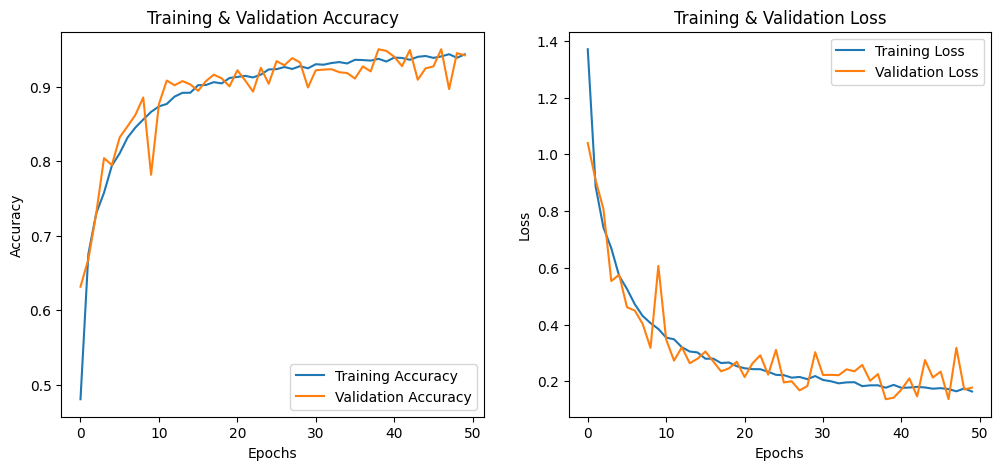

In [17]:
epochs_range = range(len(history.history['accuracy']))
# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

# Save in high quality
#plt.savefig("elbow_cnn.png", dpi=300, bbox_inches="tight")  # PNG format
#plt.savefig("elbow_cnn.svg", dpi=300, bbox_inches="tight")  # SVG format

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


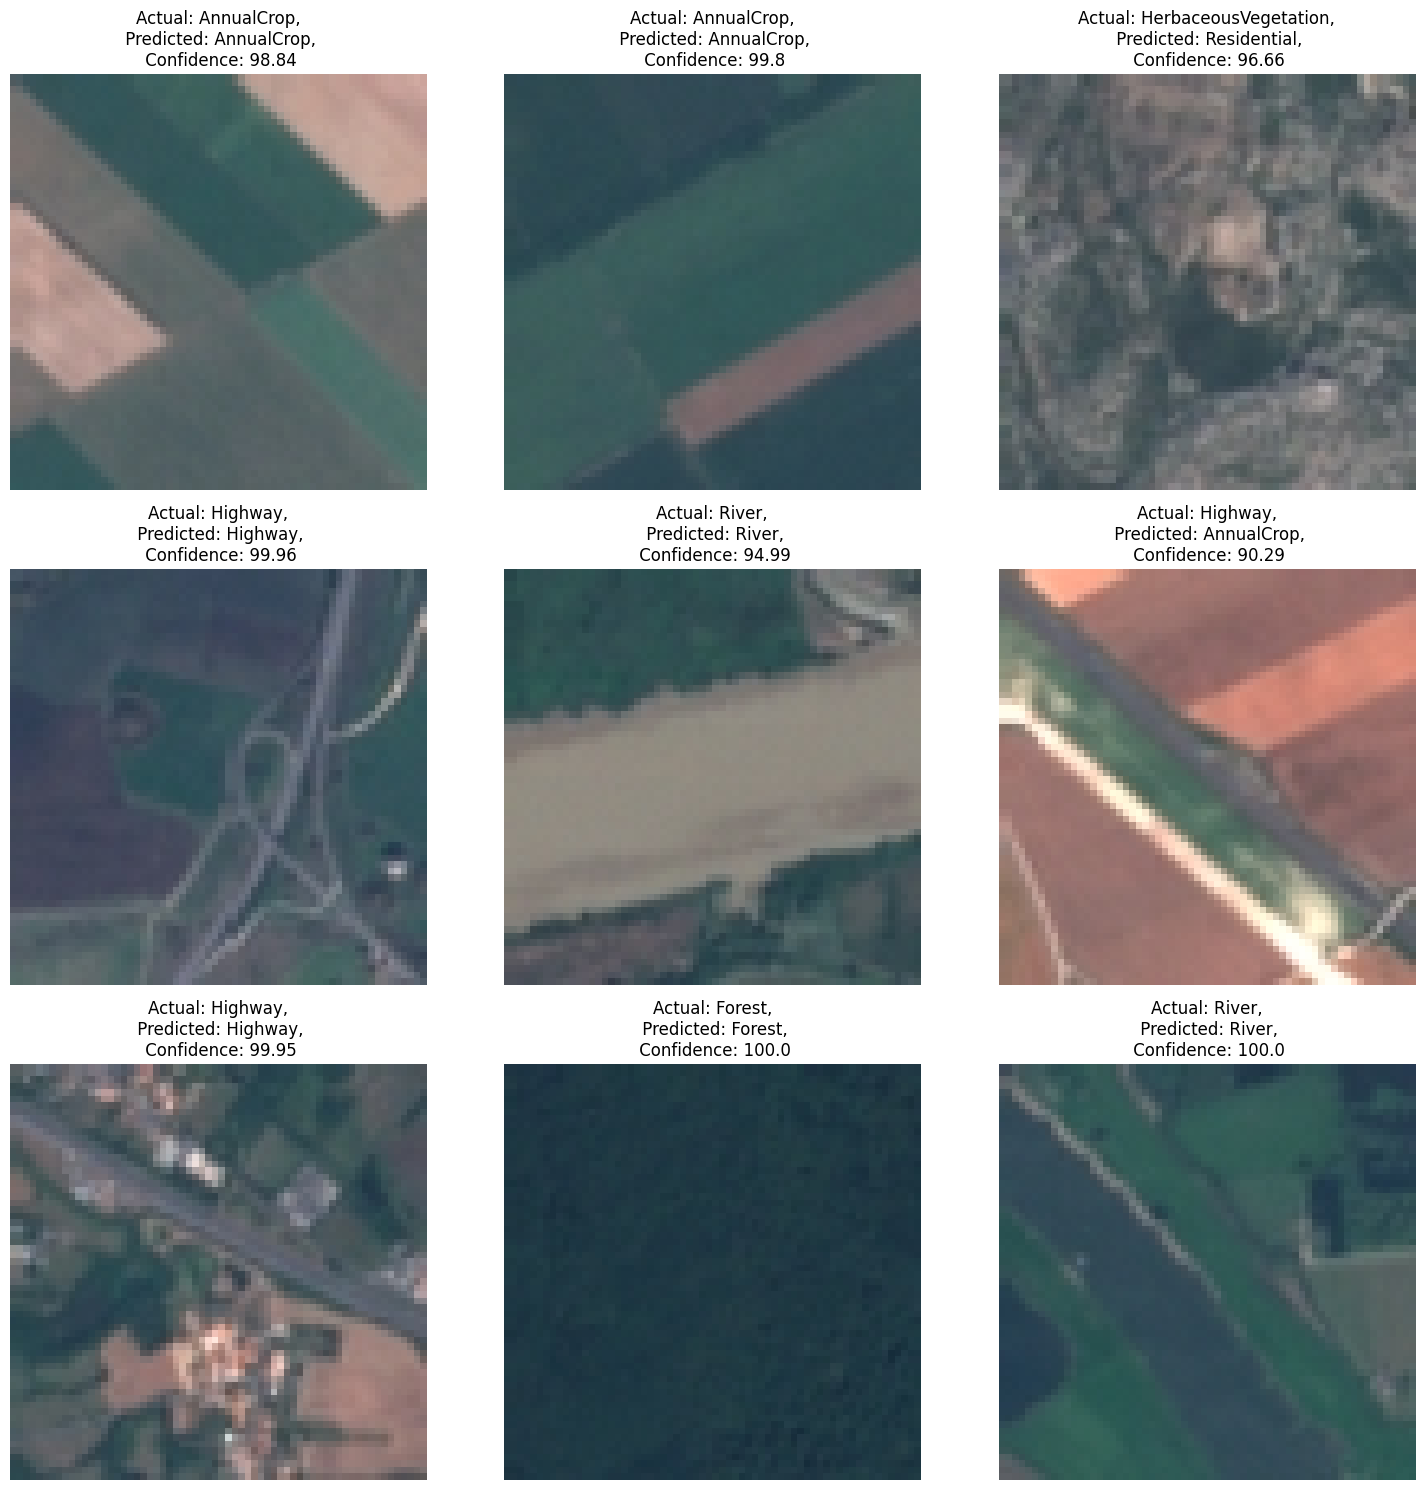

In [18]:
plt.figure(figsize=(15, 15))
for images2, labels in test.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images2[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images2[i].numpy(), images.class_names)
        actual_class = images.class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}")
        plt.axis("off")

plt.tight_layout()  # Ensure spacing is good

# Save in high quality
#plt.savefig("prediction_grid_cnn.png", dpi=300, bbox_inches="tight")  # PNG format
#plt.savefig("prediction_grid_cnn.svg", dpi=300, bbox_inches="tight")  # SVG format

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


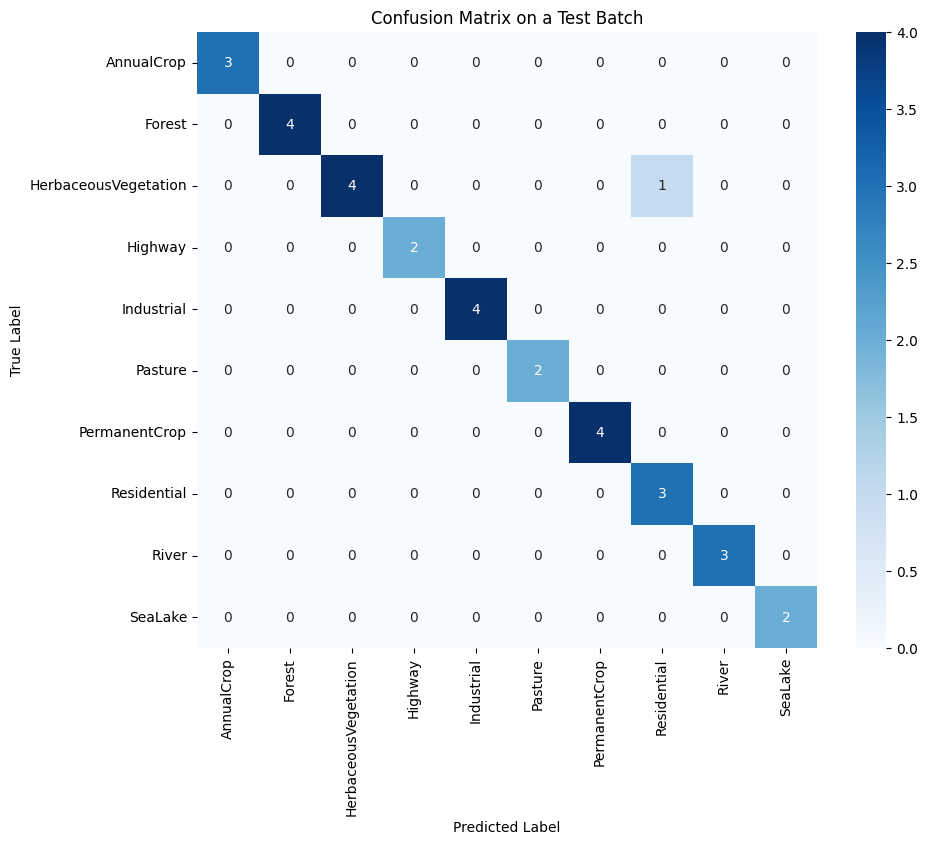

In [19]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Take a portion of the test set for a stable evaluation (do NOT shuffle)
cm_dataset = test.take(5)  # Take a single batch to ensure label alignment

# Extract images and labels from `cm_dataset`
x_cm, y_true = next(iter(cm_dataset))  # Extract a single batch
y_true = y_true.numpy()  # Convert TensorFlow tensor to NumPy array

# Predict on the extracted batch
y_pred_probs = model.predict(x_cm)  # Get probability scores
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
ax = plt.subplot(1, 1, 1)  # Single subplot for consistency
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=images.class_names, yticklabels=images.class_names)

plt.title("Confusion Matrix on a Test Batch")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Save in high quality
#plt.savefig("cm_cnn.png", dpi=300, bbox_inches="tight")  # PNG format
#plt.savefig("cm_cnn.svg", dpi=300, bbox_inches="tight")  # SVG format

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


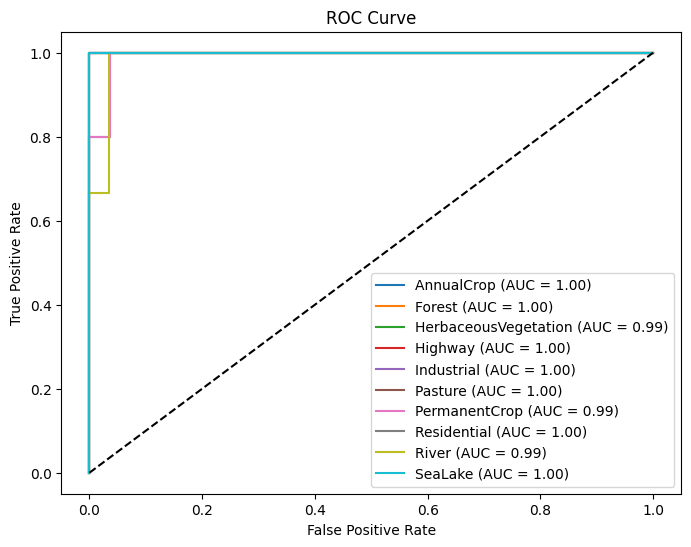

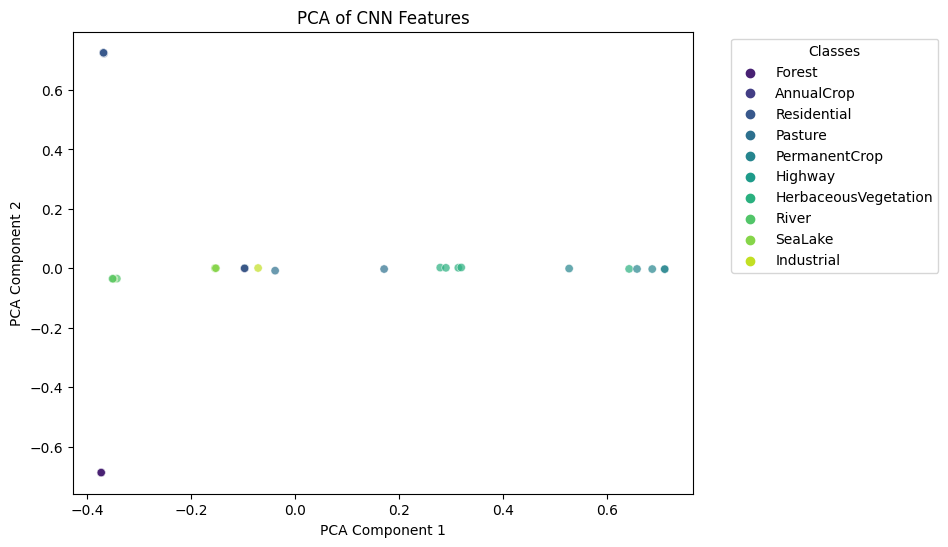

In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.preprocessing import label_binarize

# Take a portion of the test set for a stable evaluation (do NOT shuffle)
cm_dataset = test.take(5)  # Take a single batch to ensure label alignment

# Extract images and labels from `cm_dataset`
x_cm, y_true = next(iter(cm_dataset))  # Extract a single batch
y_true = y_true.numpy()  # Convert TensorFlow tensor to NumPy array

# Predict on the extracted batch
y_pred_probs = model.predict(x_cm)  # Get probability scores
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels


num_classes = len(images.class_names)
y_test_bin = label_binarize(y_true, classes=np.arange(num_classes))

plt.figure(figsize=(8, 6))
for i, class_name in enumerate(images.class_names):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
#plt.savefig("roc_cnn.png", dpi=300, bbox_inches="tight")
#plt.savefig("roc_cnn.svg", dpi=300, bbox_inches="tight")
plt.show()


# PCA Visualization
# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(y_pred_probs)

# Convert y_true to class names
class_names = np.array(images.class_names)
y_labels = class_names[y_true]  # Map numerical labels to class names

# Plot PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_labels, palette='viridis', alpha=0.7)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of CNN Features')
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside
#plt.savefig("pca_cnn.png", dpi=300, bbox_inches="tight")
#plt.savefig("pca_cnn.svg", dpi=300, bbox_inches="tight")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


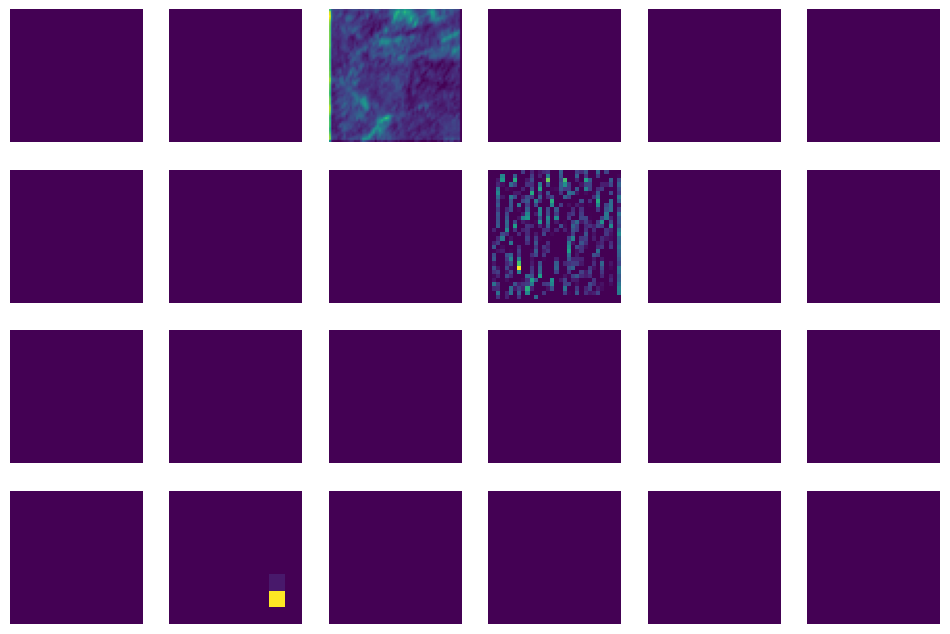

In [21]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Step 1: Extract convolutional layer outputs
layer_outputs = [layer.output for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)]

# Step 2: Create activation model
activation_model = tf.keras.models.Model(inputs=model.inputs, outputs=layer_outputs)

# Step 3: Convert tensor to NumPy and reshape
sample_input = x_cm[0].numpy().reshape(1, *x_cm[0].shape)  # Convert TensorFlow tensor to NumPy

# Step 4: Get feature map activations
activations = activation_model.predict(sample_input)

# Step 5: Plot feature maps
fig, axes = plt.subplots(len(activations), 6, figsize=(12, len(activations) * 2))

for i, activation in enumerate(activations):
    for j in range(6):
        if j < activation.shape[-1]:  # Ensure the channel exists
            axes[i, j].imshow(activation[0, :, :, j], cmap='viridis')
            axes[i, j].axis('off')

#plt.savefig("feature_maps.png", dpi=300, bbox_inches="tight")
#plt.savefig("feature_maps.svg", dpi=300, bbox_inches="tight")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


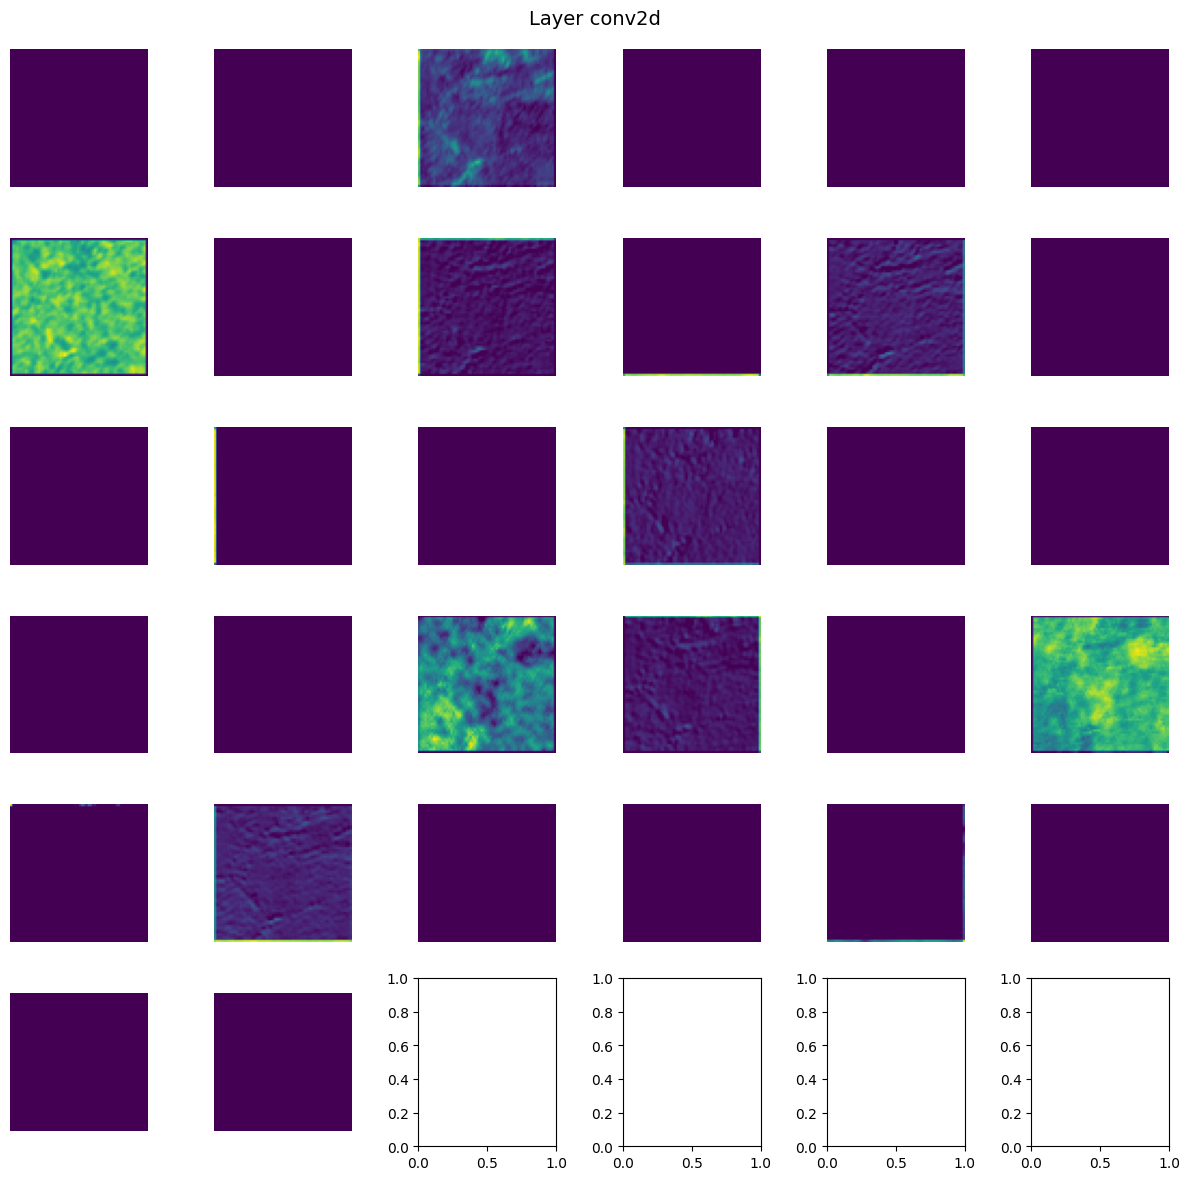

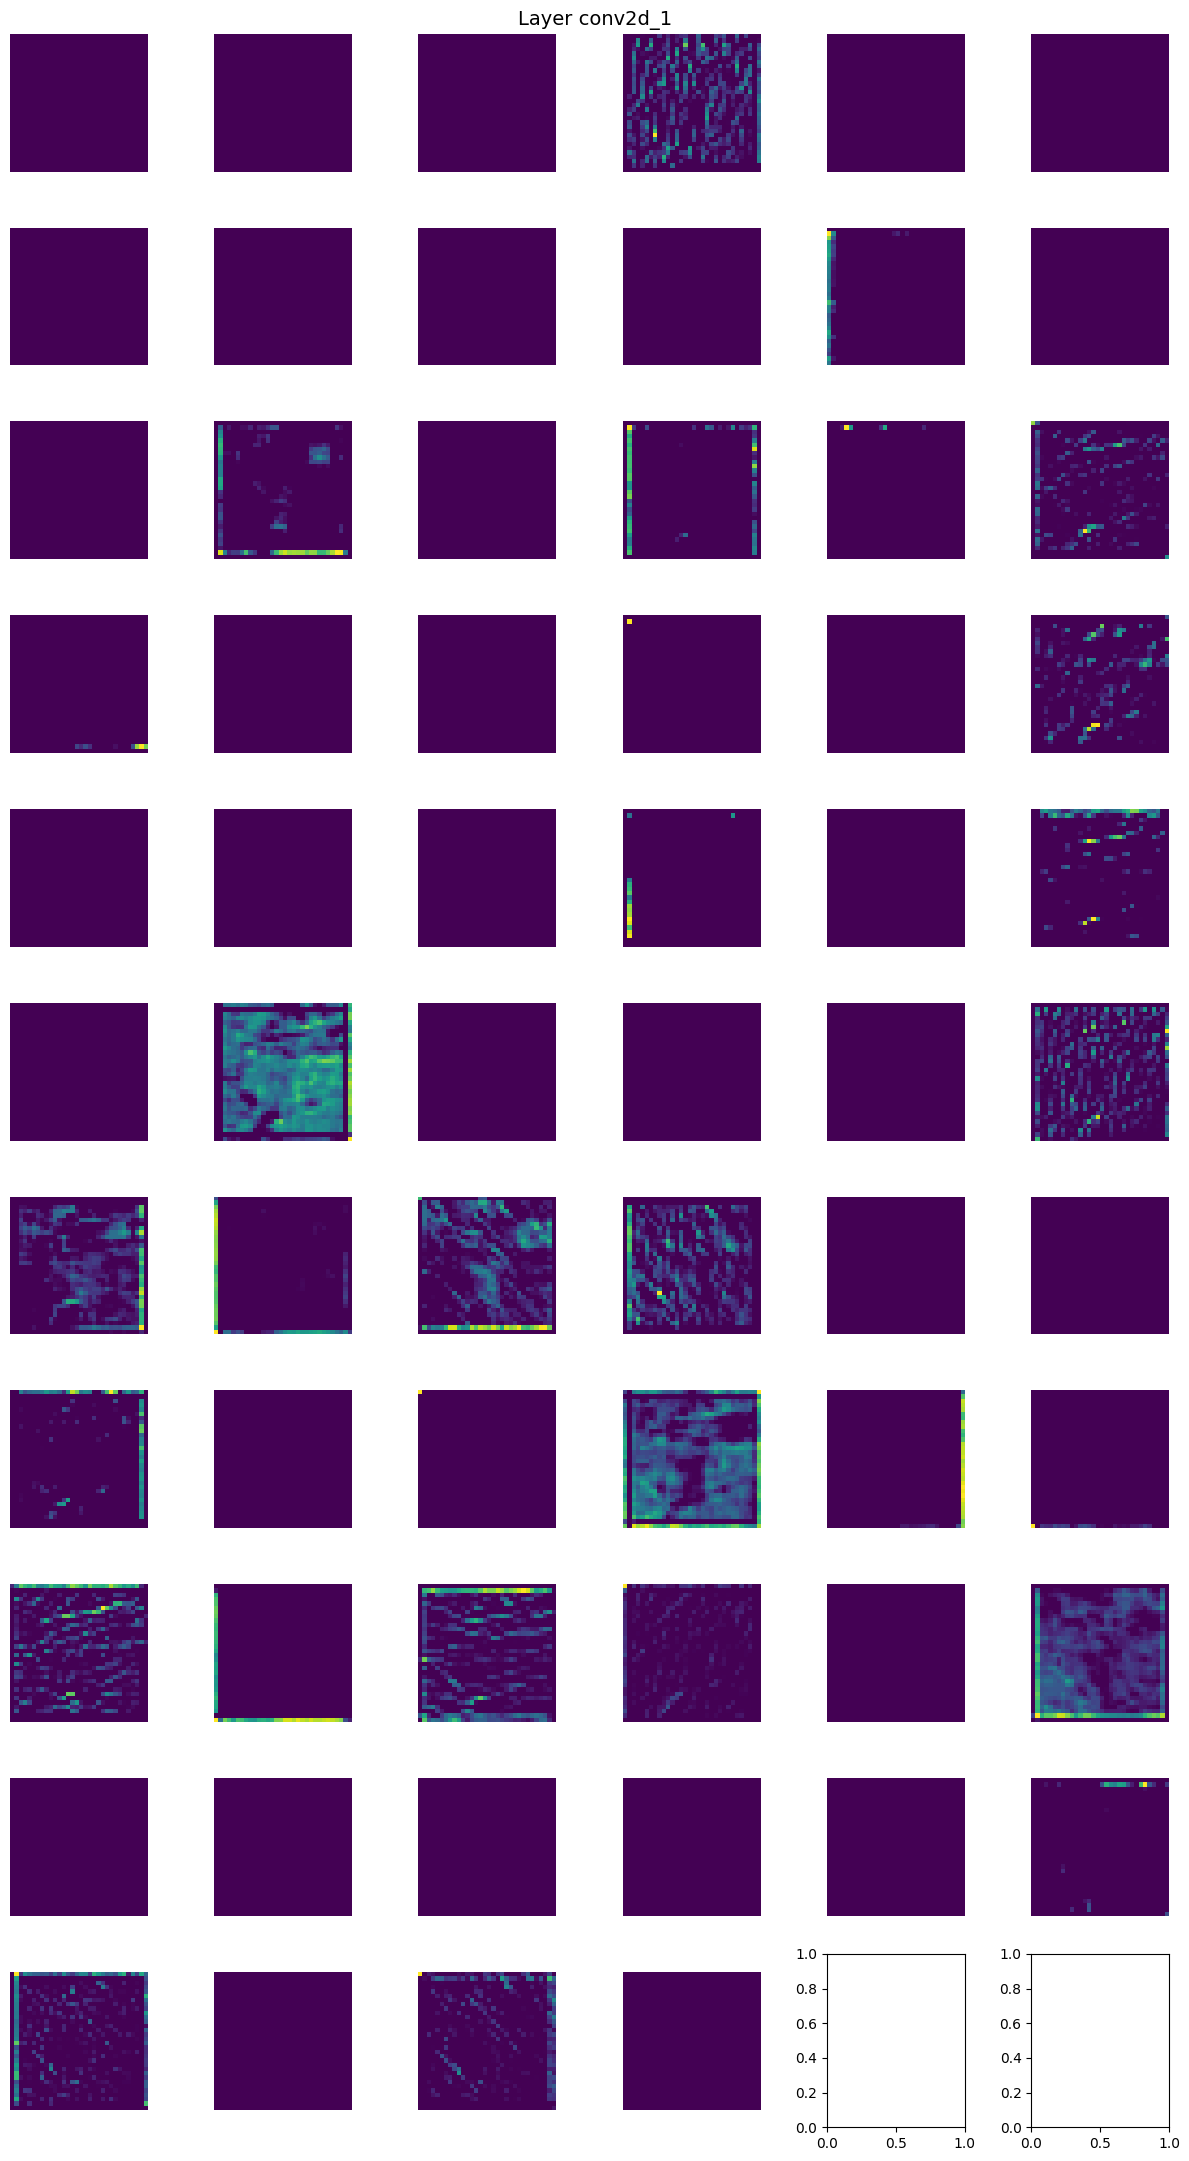

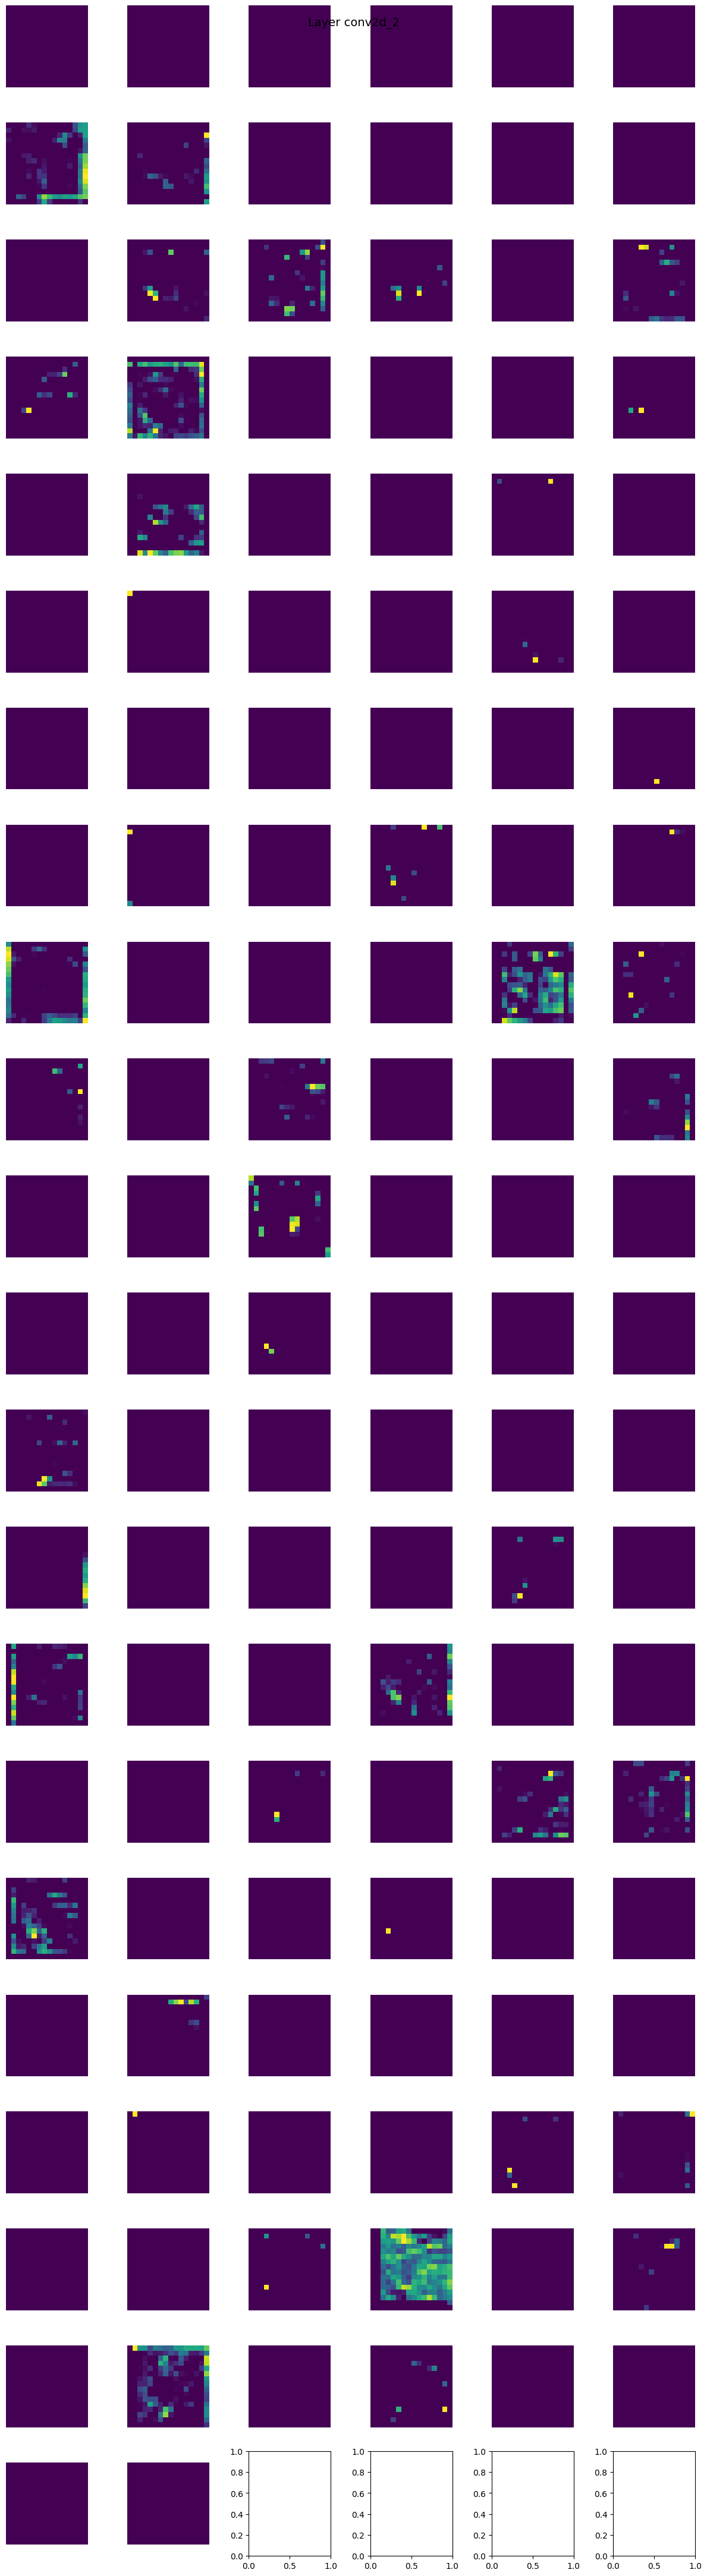

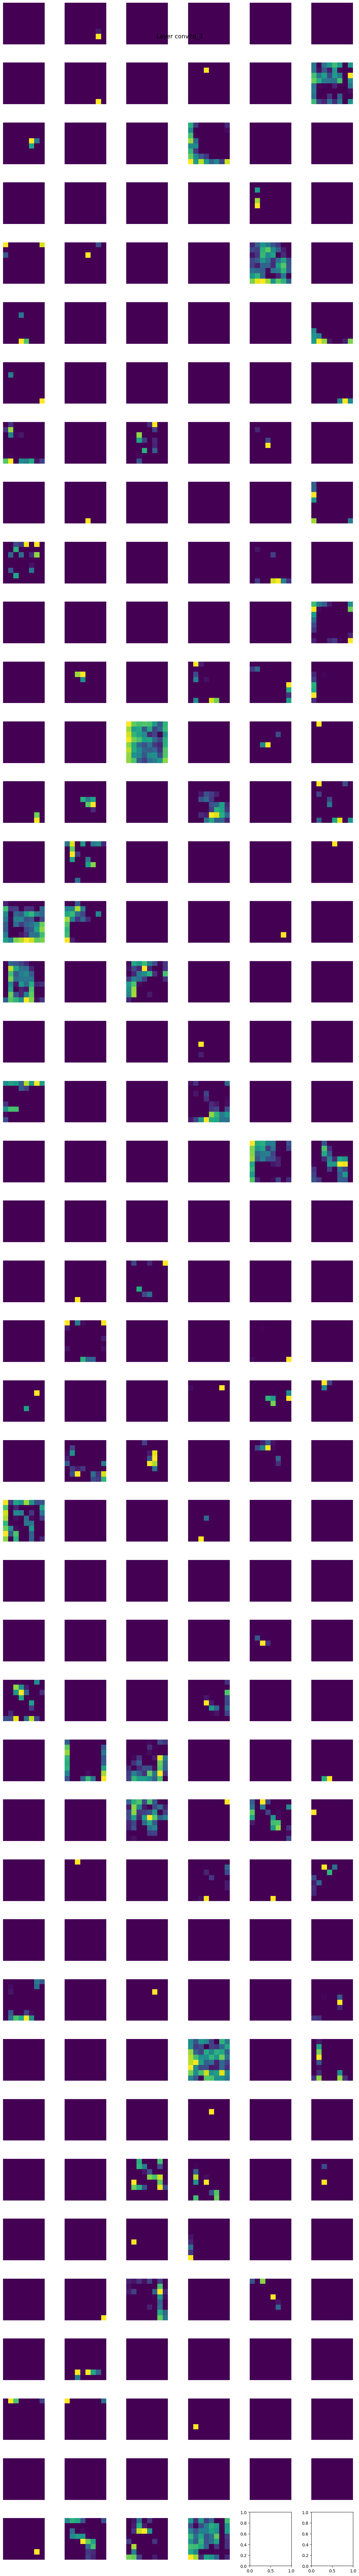

In [22]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Select convolutional layers only
conv_layers = [layer for layer in model.layers if 'conv' in layer.name]

# Create a new model to extract outputs from each convolutional layer
activation_model = tf.keras.models.Model(inputs=model.inputs, outputs=[layer.output for layer in conv_layers])

# Select a test image (make sure it's preprocessed the same way as your training data)
sample_input = np.expand_dims(x_cm[0], axis=0)  # Ensure batch dimension

# Get activations
activations = activation_model.predict(sample_input)

# Plot activations for each layer separately
for layer_idx, activation in enumerate(activations):
    num_filters = activation.shape[-1]  # Number of feature maps in this layer
    num_cols = 6  # Number of columns in subplot
    num_rows = (num_filters // num_cols) + (num_filters % num_cols > 0)  # Compute rows dynamically
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 2))
    fig.suptitle(f"Layer {conv_layers[layer_idx].name}", fontsize=14)

    for i in range(num_filters):
        row, col = divmod(i, num_cols)
        ax = axes[row, col] if num_rows > 1 else axes[col]
        ax.imshow(activation[0, :, :, i], cmap='viridis')
        ax.axis("off")

    plt.tight_layout()
    plt.show()


In [23]:
# # Get only numeric folder names
# existing_versions = [int(i) for i in os.listdir("/kaggle/working/") if i.isdigit()]

# # Determine the next version number
# model_version = max(existing_versions, default=0) + 1

# # Define the save path with `.keras` extension
# save_path = f"/kaggle/working/{model_version}.keras"

# # Save the model
# model.save(save_path)
# print(f"Model saved as {save_path}")

# model = tf.keras.models.load_model("/kaggle/working/1.keras")




## VGG16 

In [24]:
# Load the VGG16 base model (excluding top layers)
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model
vgg16_base.trainable = False

# Define the model
model_vgg16 = Sequential([
    Input(shape=input_shape),  # Explicit input layer
    vgg16_base,

    # Additional Conv2D layers for a deeper feature extraction
    Conv2D(256, kernel_size=(3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),  # 4 -> 2

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax"),
])

# Compile the model
model_vgg16.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model_vgg16.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 2, 2, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 2, 2, 256)           │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,928,778 (60.76 MB)

 Trainable params: 1,214,090 (4.63 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [25]:
history_vgg16 = model_vgg16.fit(
    train,
    epochs=50,
    batch_size=batch_size,
    validation_data=val,
    verbose=1
)

Epoch 1/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 43s 41ms/step - accuracy: 0.5334 - loss: 3.1100 - val_accuracy: 0.8813 - val_loss: 0.3941
Epoch 2/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 31s 31ms/step - accuracy: 0.8059 - loss: 0.6381 - val_accuracy: 0.9226 - val_loss: 0.2484
Epoch 3/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 31s 33ms/step - accuracy: 0.8375 - loss: 0.5164 - val_accuracy: 0.9193 - val_loss: 0.2454
Epoch 4/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 31s 32ms/step - accuracy: 0.8682 - loss: 0.4266 - val_accuracy: 0.9408 - val_loss: 0.1912
Epoch 5/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 31s 32ms/step - accuracy: 0.8869 - loss: 0.3481 - val_accuracy: 0.9494 - val_loss: 0.1638
Epoch 6/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 31s 31ms/step - accuracy: 0.9019 - loss: 0.3020 - val_accuracy: 0.9416 - val_loss: 0.1614
Epoch 7/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 31s 33ms/step - accuracy: 0.9211 - loss: 0.2563 - val_accuracy: 0.9598 - val_loss: 0.1109
Epoch 8/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 31s 31ms/step - accuracy: 0.9204 - loss: 0.2437 - 

In [26]:
model_vgg16.evaluate(test)

85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.9993 - loss: 0.0015


[0.0015563028864562511, 0.9992647171020508]

### VGG16 Evaluation

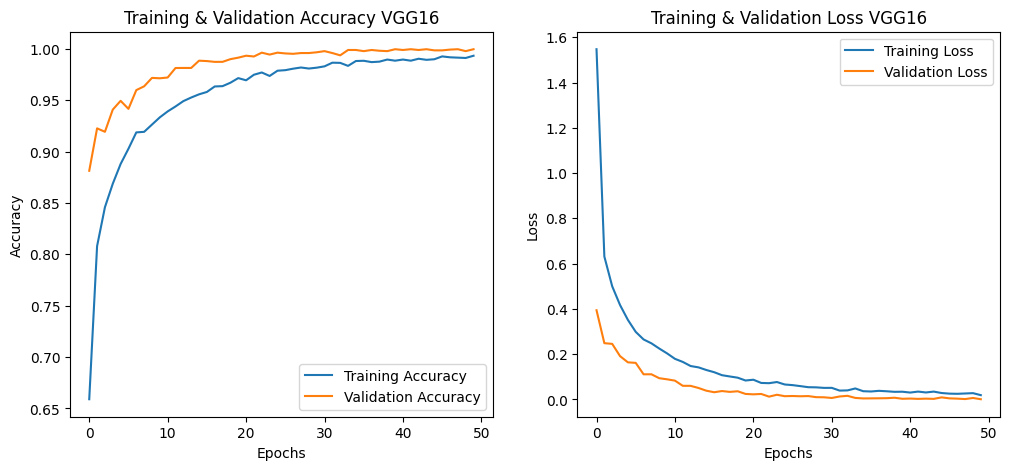

In [27]:
epochs_range = range(len(history_vgg16.history['accuracy']))
# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_vgg16.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history_vgg16.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy VGG16')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_vgg16.history['loss'], label='Training Loss')
plt.plot(epochs_range, history_vgg16.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss VGG16')



# Save in high quality
#plt.savefig("elbow_vgg16.png", dpi=300, bbox_inches="tight")  # PNG format
#plt.savefig("elbow_vgg16.svg", dpi=300, bbox_inches="tight")  # SVG format


plt.show()

In [28]:
# Get only numeric folder names
existing_versions = [int(i) for i in os.listdir("/kaggle/working/") if i.isdigit()]

# Determine the next version number
model_version = max(existing_versions, default=0) + 1

# Define the save path with `.keras` extension
save_path = f"/kaggle/working/{model_version}_vgg16.keras"

# Save the model
model_vgg16.save(save_path)
print(f"Model saved as {save_path}")

model_vgg16 = tf.keras.models.load_model("/kaggle/working/1_vgg16.keras")

Model saved as /kaggle/working/1_vgg16.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


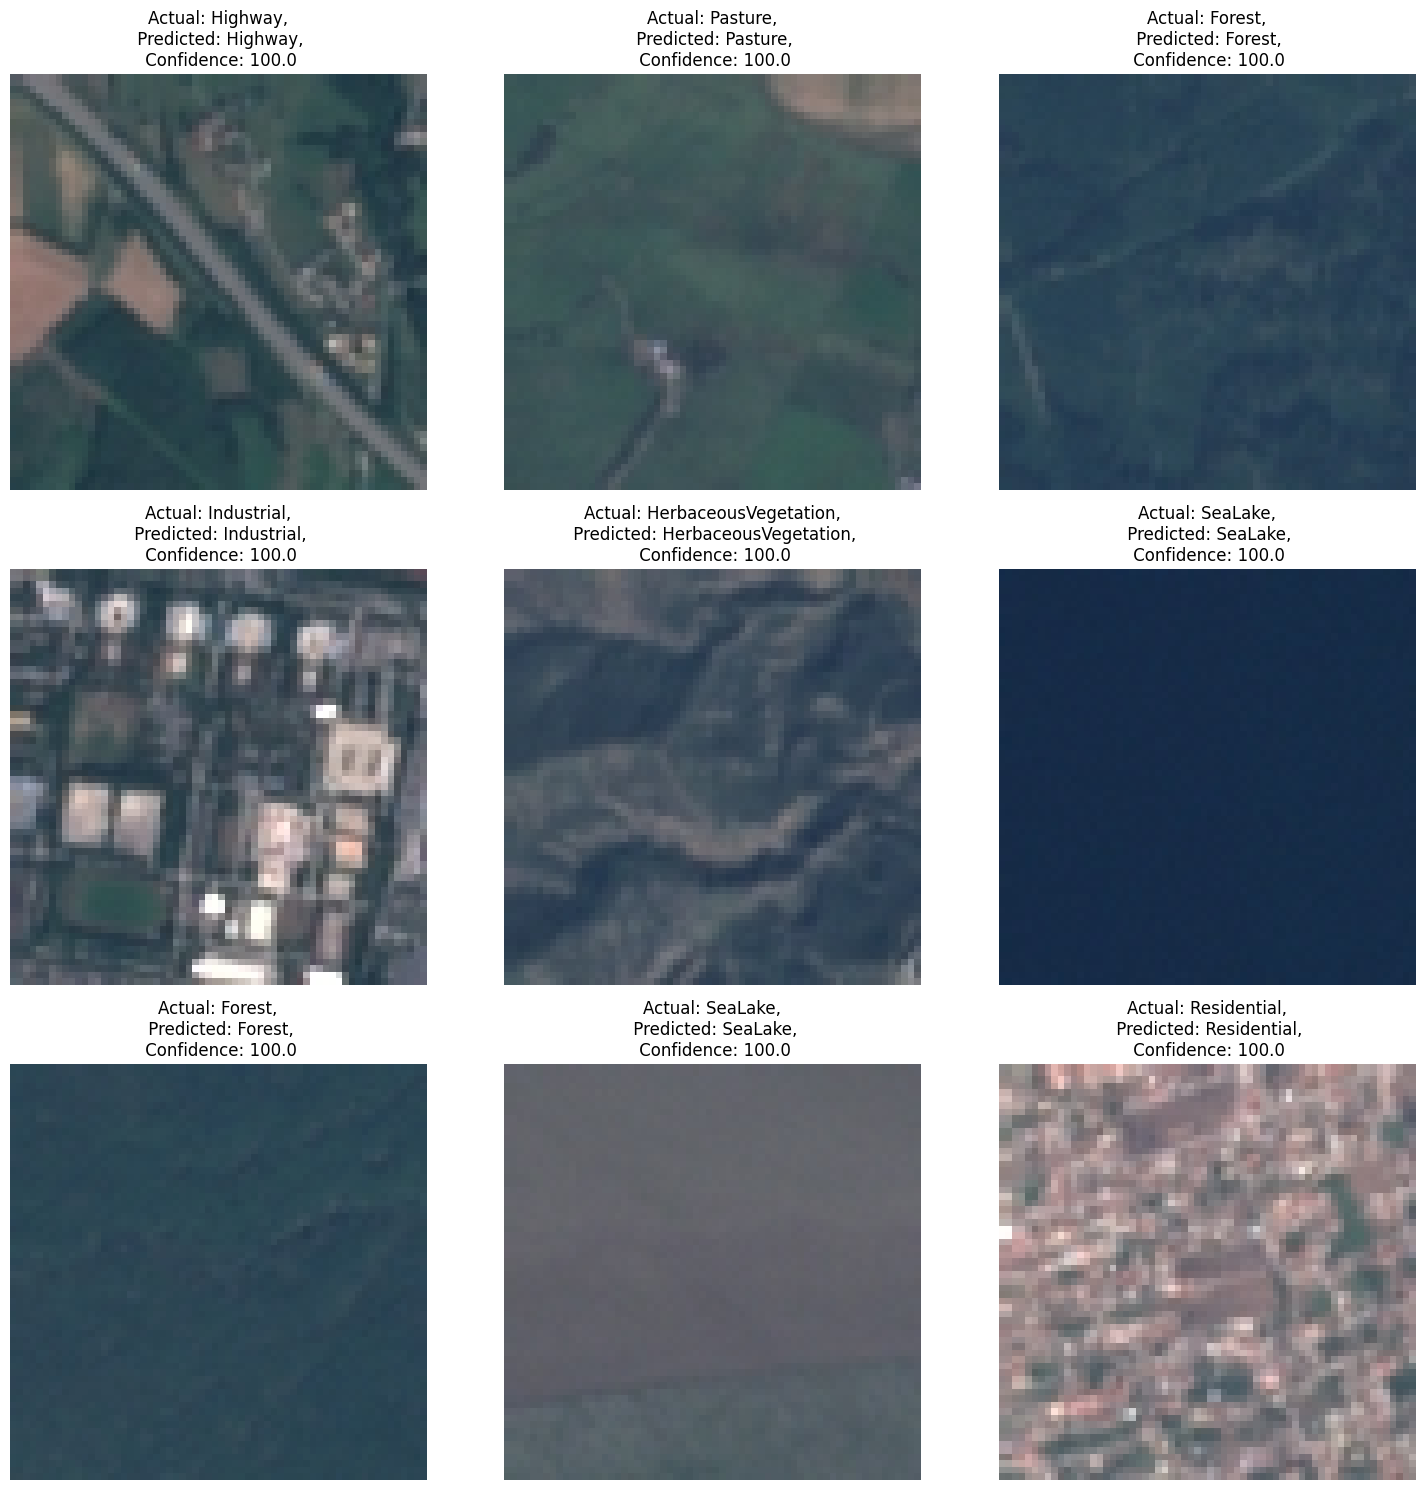

In [29]:
plt.figure(figsize=(15, 15))
for images2, labels in test.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images2[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model_vgg16, images2[i].numpy(), images.class_names)
        actual_class = images.class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}")
        plt.axis("off")

plt.tight_layout()  # Ensure spacing is good

# Save in high quality
#plt.savefig("prediction_grid_vgg16.png", dpi=300, bbox_inches="tight")  # PNG format
#plt.savefig("prediction_grid_vgg16.svg", dpi=300, bbox_inches="tight")  # SVG format

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


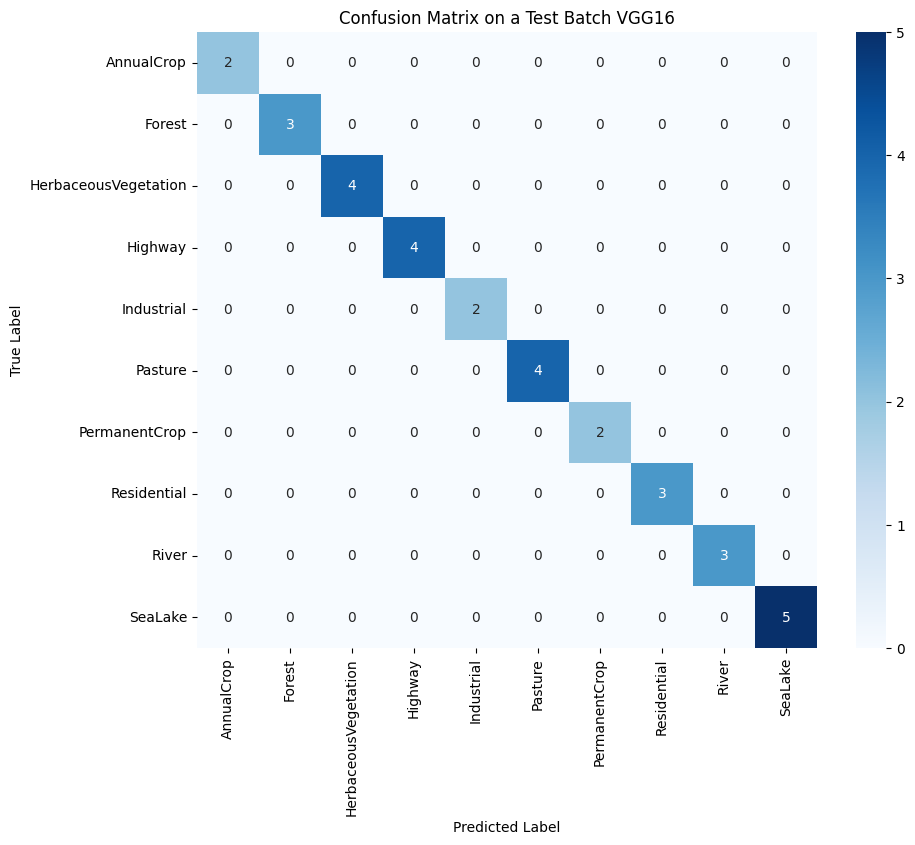

In [30]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Take a portion of the test set for a stable evaluation (do NOT shuffle)
cm_dataset = test.take(5)  # Take a single batch to ensure label alignment

# Extract images and labels from `cm_dataset`
x_cm, y_true = next(iter(cm_dataset))  # Extract a single batch
y_true = y_true.numpy()  # Convert TensorFlow tensor to NumPy array

# Predict on the extracted batch
y_pred_probs = model_vgg16.predict(x_cm)  # Get probability scores
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
ax = plt.subplot(1, 1, 1)  # Single subplot for consistency
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=images.class_names, yticklabels=images.class_names)

plt.title("Confusion Matrix on a Test Batch VGG16")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")


#plt.savefig("cm_vgg16.png", dpi=300, bbox_inches="tight")  # PNG format

#plt.savefig("cm_vgg16.svg", dpi=300, bbox_inches="tight")  # SVG format

plt.show()


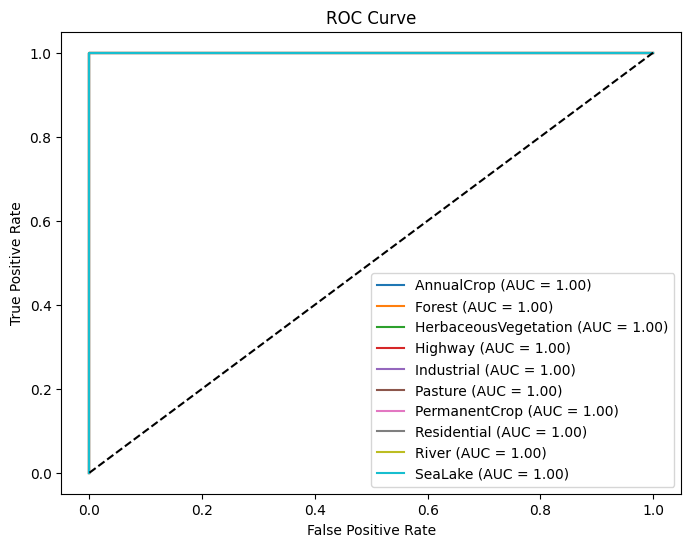

In [31]:
num_classes = len(images.class_names)
y_test_bin = label_binarize(y_true, classes=np.arange(num_classes))

plt.figure(figsize=(8, 6))
for i, class_name in enumerate(images.class_names):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
#plt.savefig("roc_vgg.png", dpi=300, bbox_inches="tight")
#plt.savefig("roc_vgg.svg", dpi=300, bbox_inches="tight")
plt.show()


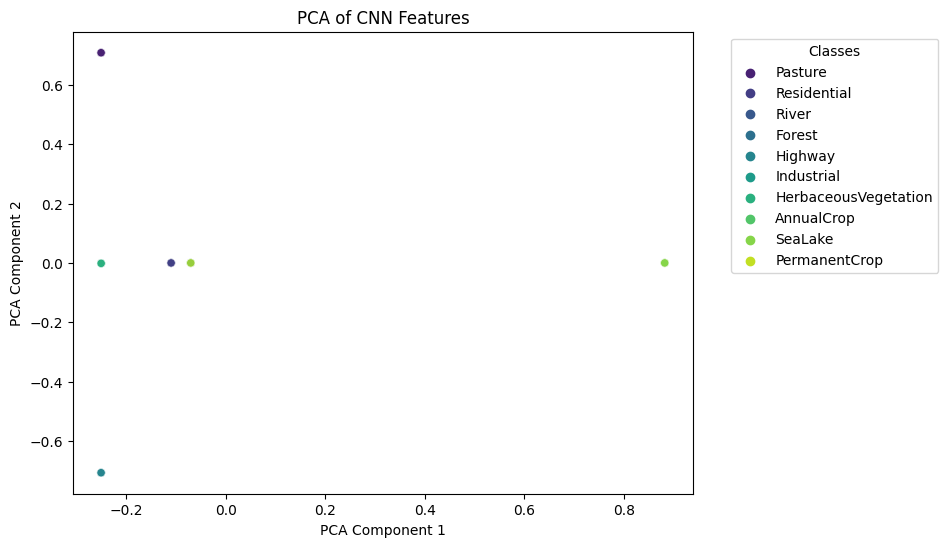

In [32]:

# PCA Visualization
# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(y_pred_probs)

# Convert y_true to class names
class_names = np.array(images.class_names)
y_labels = class_names[y_true]  # Map numerical labels to class names

# Plot PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_labels, palette='viridis', alpha=0.7)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of CNN Features')
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside
#plt.savefig("pca_cnn.png", dpi=300, bbox_inches="tight")
#plt.savefig("pca_cnn.svg", dpi=300, bbox_inches="tight")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


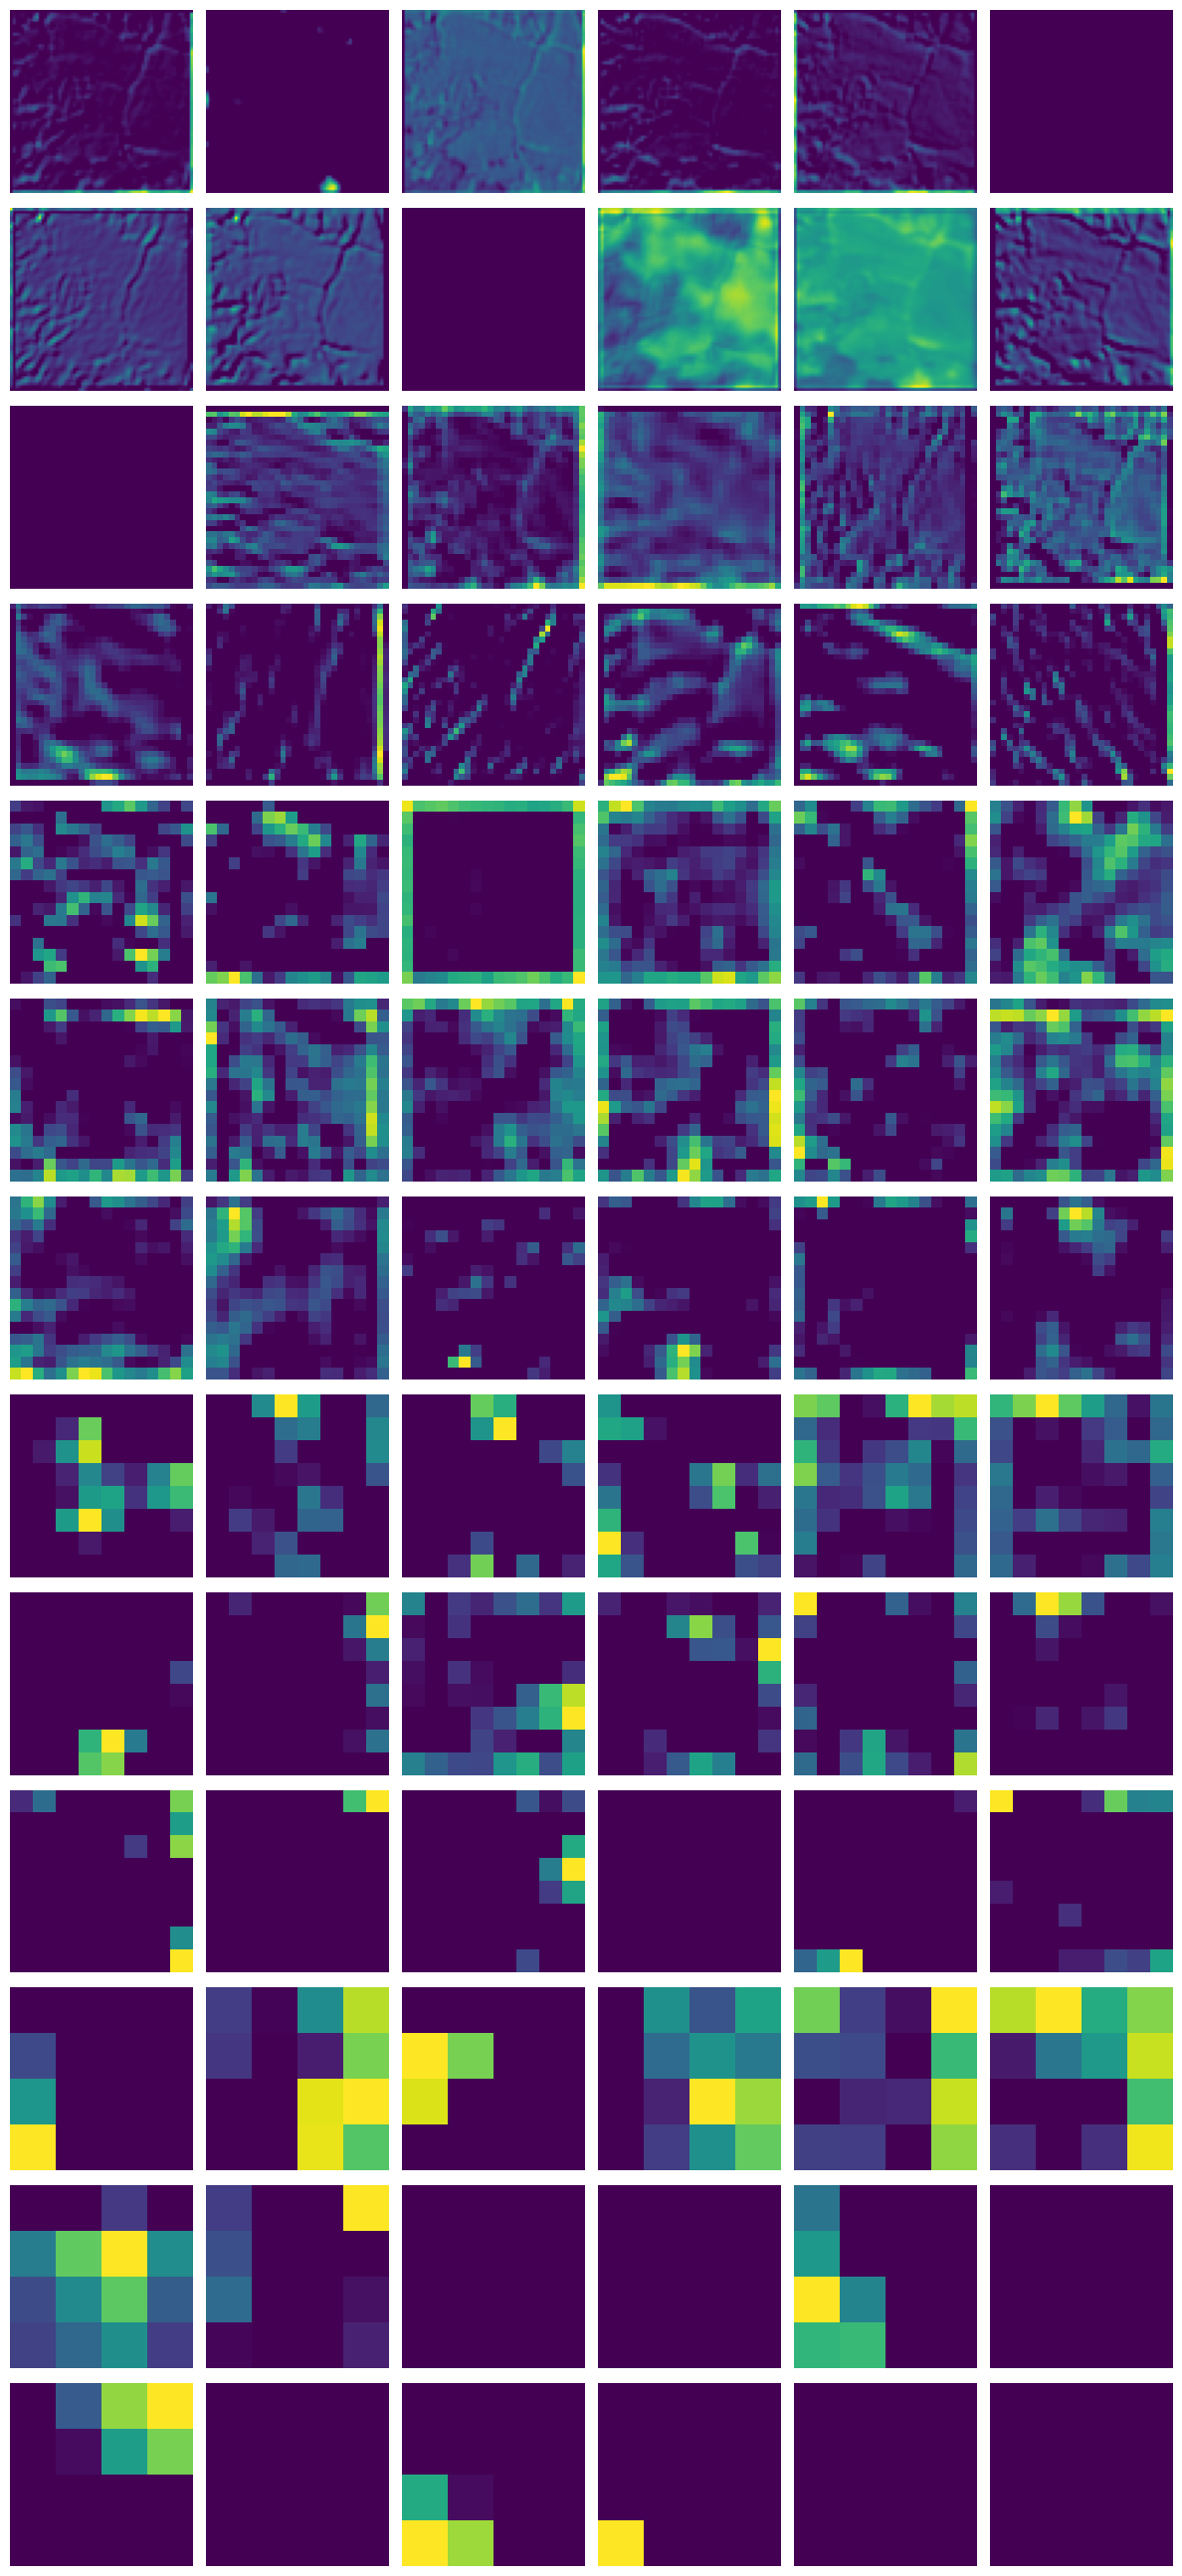

In [33]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Ensure model_vgg16 is defined (e.g., loaded from keras.applications or custom trained)
assert 'model_vgg16' in globals(), "model_vgg16 is not defined."

layer_outputs = [layer.output for layer in vgg16_base.layers if isinstance(layer, tf.keras.layers.Conv2D)]
activation_model = tf.keras.models.Model(inputs=vgg16_base.input, outputs=layer_outputs)



# Step 3: Convert tensor to NumPy and reshape
if isinstance(x_cm[0], tf.Tensor):
    sample_input = x_cm[0].numpy().reshape(1, *x_cm[0].shape)
else:
    sample_input = x_cm[0].reshape(1, *x_cm[0].shape)

# Step 4: Get feature map activations
activations = activation_model.predict(sample_input)

# Step 5: Plot feature maps
num_layers = len(activations)
num_features = 6  # Display up to 6 feature maps per layer
fig, axes = plt.subplots(num_layers, num_features, figsize=(12, num_layers * 2))

for i, activation in enumerate(activations):
    for j in range(num_features):
        if j < activation.shape[-1]:  # Ensure the channel exists
            ax = axes[i, j] if num_layers > 1 else axes[j]  # Handle single-layer cases
            ax.imshow(activation[0, :, :, j], cmap='viridis')
            ax.axis('off')

plt.tight_layout()
#plt.savefig("feature_maps_vgg.png", dpi=300, bbox_inches="tight")
#plt.savefig("feature_maps_vgg.svg", dpi=300, bbox_inches="tight")
plt.show()


## DenseNet121

In [34]:
# Load the DenseNet121 base model (excluding top layers)
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model
densenet_base.trainable = False

# Define the model
model_densenet = Sequential([
    Input(shape=input_shape),  # Explicit input layer
    densenet_base,

    # Additional Conv2D layers for a deeper feature extraction
    Conv2D(256, kernel_size=(3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),  

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax"),
])

# Compile the model
model_densenet.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model_densenet.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 2, 2, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 2, 2, 256)           │       2,359,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,431,242 (35.98 MB)

 Trainable params: 2,393,738 (9.13 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [35]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

history_dense = model_densenet.fit(
    train,
    epochs=50,
    batch_size=batch_size,
    validation_data=val,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 60s 45ms/step - accuracy: 0.5351 - loss: 1.9918 - val_accuracy: 0.7887 - val_loss: 0.6450
Epoch 2/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.7195 - loss: 0.8699 - val_accuracy: 0.8371 - val_loss: 0.5029
Epoch 3/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - accuracy: 0.7637 - loss: 0.7343 - val_accuracy: 0.8512 - val_loss: 0.4565
Epoch 4/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 31s 32ms/step - accuracy: 0.7752 - loss: 0.6676 - val_accuracy: 0.8586 - val_loss: 0.4142
Epoch 5/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 33s 33ms/step - accuracy: 0.7929 - loss: 0.6205 - val_accuracy: 0.8631 - val_loss: 0.3965
Epoch 6/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - accuracy: 0.8073 - loss: 0.5866 - val_accuracy: 0.8657 - val_loss: 0.3793
Epoch 7/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - accuracy: 0.8228 - loss: 0.5386 - val_accuracy: 0.8687 - val_loss: 0.3691
Epoch 8/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 31s 31ms/step - accuracy: 0.8263 - loss: 0.5113 - 

In [36]:
model_densenet.evaluate(test)

85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.9714 - loss: 0.0910


[0.0808766558766365, 0.9735293984413147]

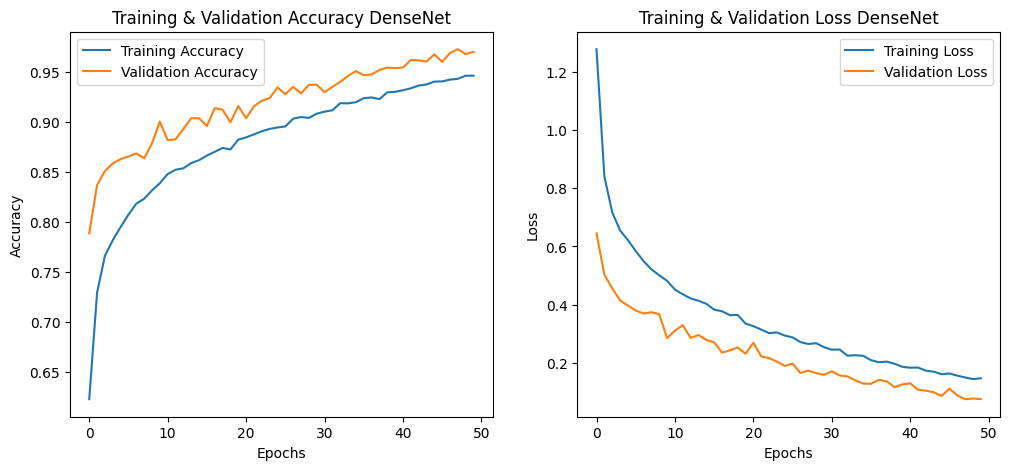

In [37]:
epochs_range = range(len(history_dense.history['accuracy']))
# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_dense.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history_dense.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy DenseNet')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_dense.history['loss'], label='Training Loss')
plt.plot(epochs_range, history_dense.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss DenseNet')

#plt.savefig("elbow_densenet.png", dpi=300, bbox_inches="tight")  # PNG format
#plt.savefig("elbow_densenet.svg", dpi=300, bbox_inches="tight")  # SVG format

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


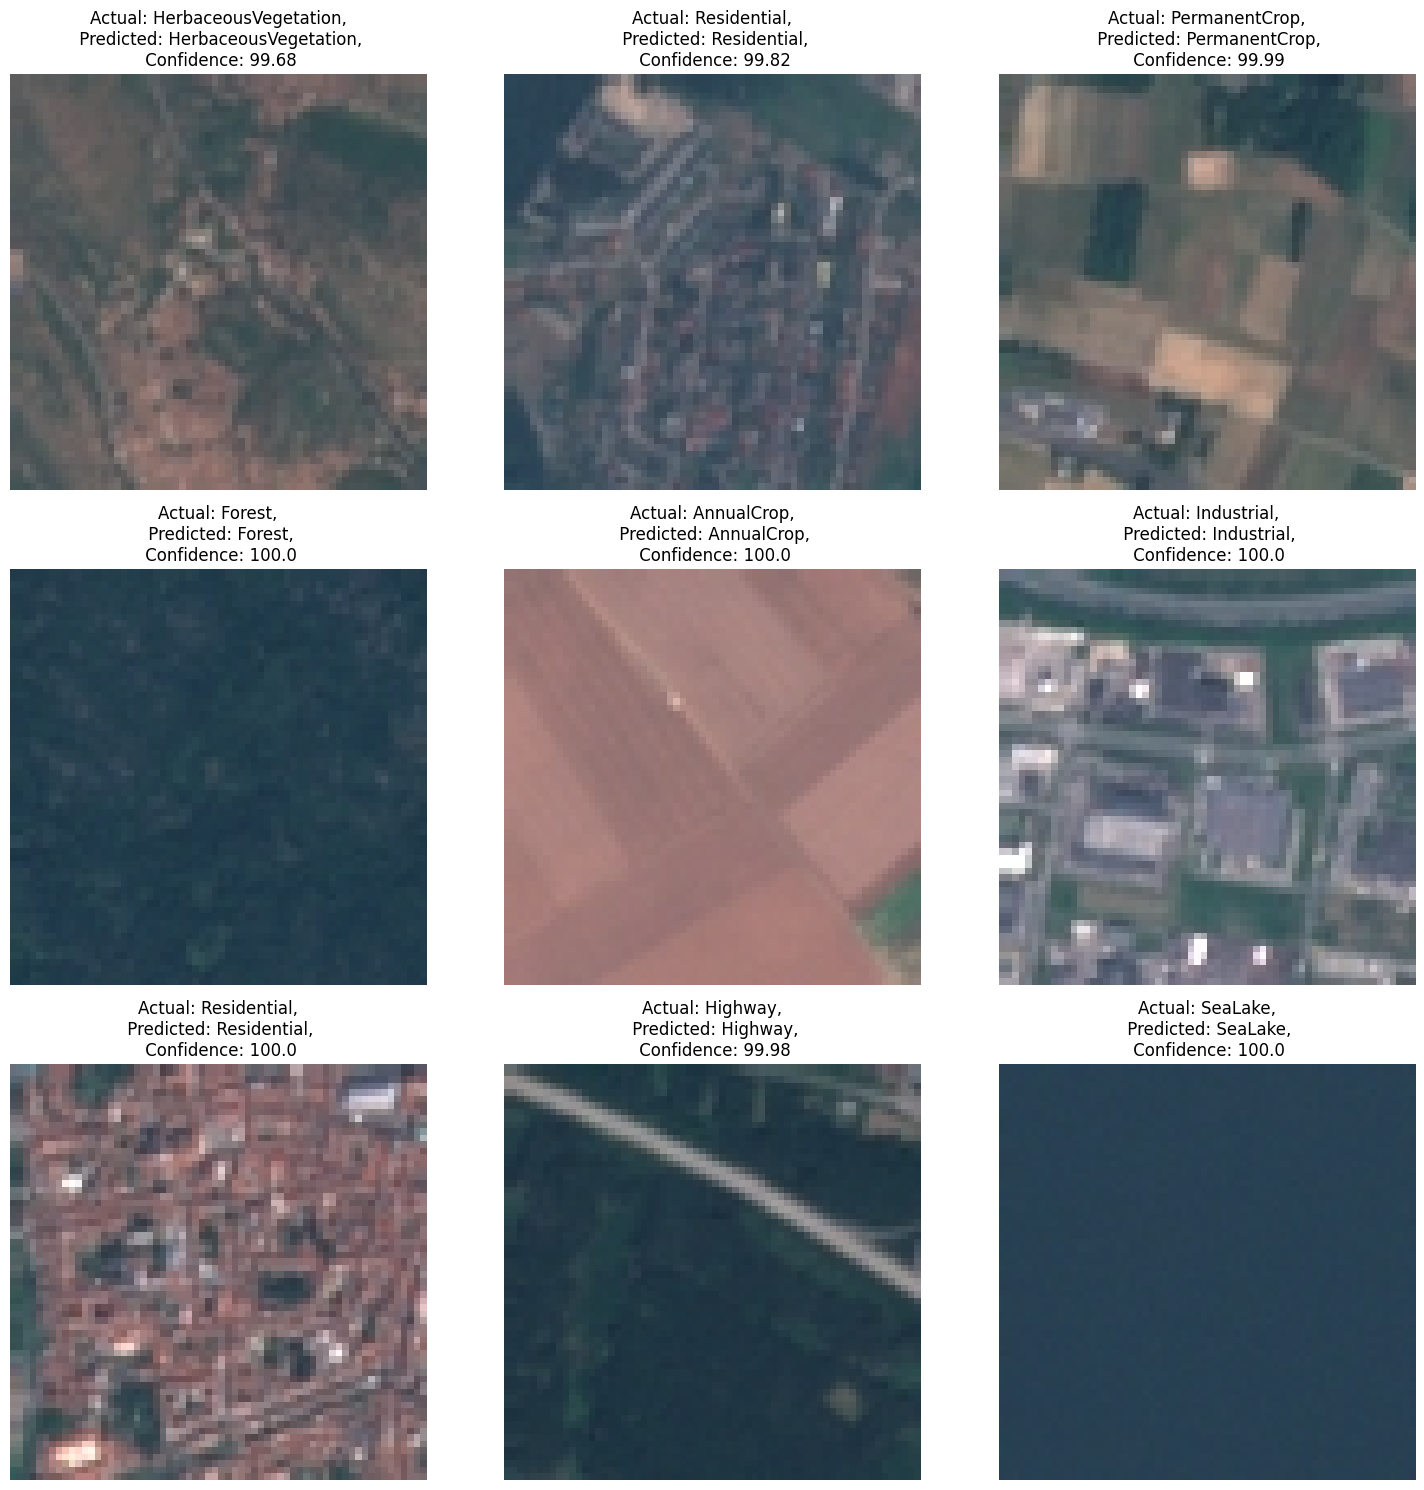

In [38]:
plt.figure(figsize=(15, 15))
for images2, labels in test.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images2[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model_densenet, images2[i].numpy(), images.class_names)
        actual_class = images.class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}")
        plt.axis("off")


plt.tight_layout()  # Ensure spacing is good

# Save in high quality
#plt.savefig("prediction_grid_densenet.png", dpi=300, bbox_inches="tight")  # PNG format
#plt.savefig("prediction_grid_densenet.svg", dpi=300, bbox_inches="tight")  # SVG format

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


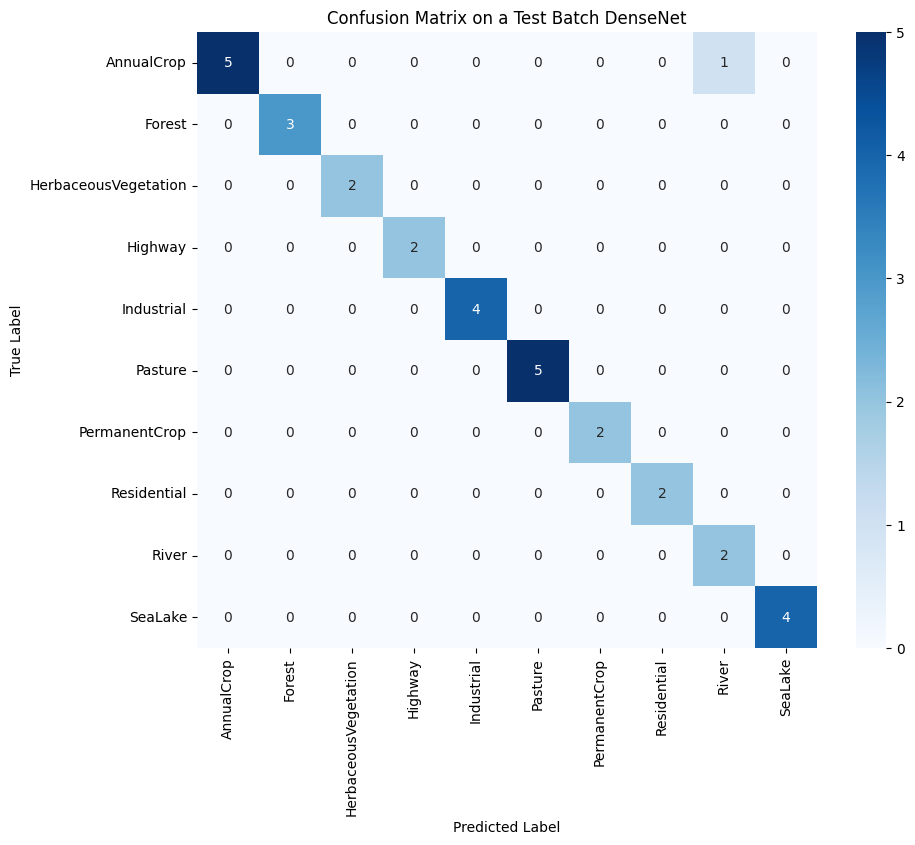

In [39]:
# Take a portion of the test set for a stable evaluation (do NOT shuffle)
cm_dataset = test.take(5)  # Take a single batch to ensure label alignment

# Extract images and labels from `cm_dataset`
x_cm, y_true = next(iter(cm_dataset))  # Extract a single batch
y_true = y_true.numpy()  # Convert TensorFlow tensor to NumPy array

# Predict on the extracted batch
y_pred_probs = model_densenet.predict(x_cm)  # Get probability scores
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
ax = plt.subplot(1, 1, 1)  # Single subplot for consistency
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=images.class_names, yticklabels=images.class_names)

plt.title("Confusion Matrix on a Test Batch DenseNet")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

#plt.savefig("cm_densenet.png", dpi=300, bbox_inches="tight")  # PNG format
#plt.savefig("cm_densenet.svg", dpi=300, bbox_inches="tight")  # SVG format

plt.show()


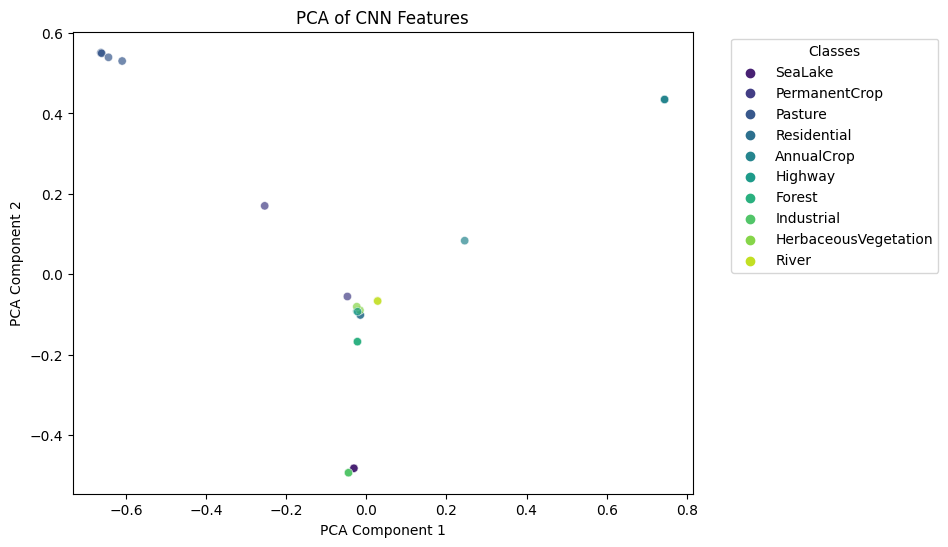

In [40]:

# PCA Visualization
# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(y_pred_probs)

# Convert y_true to class names
class_names = np.array(images.class_names)
y_labels = class_names[y_true]  # Map numerical labels to class names

# Plot PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_labels, palette='viridis', alpha=0.7)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of CNN Features')
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside
#plt.savefig("pca_cnn.png", dpi=300, bbox_inches="tight")
#plt.savefig("pca_cnn.svg", dpi=300, bbox_inches="tight")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


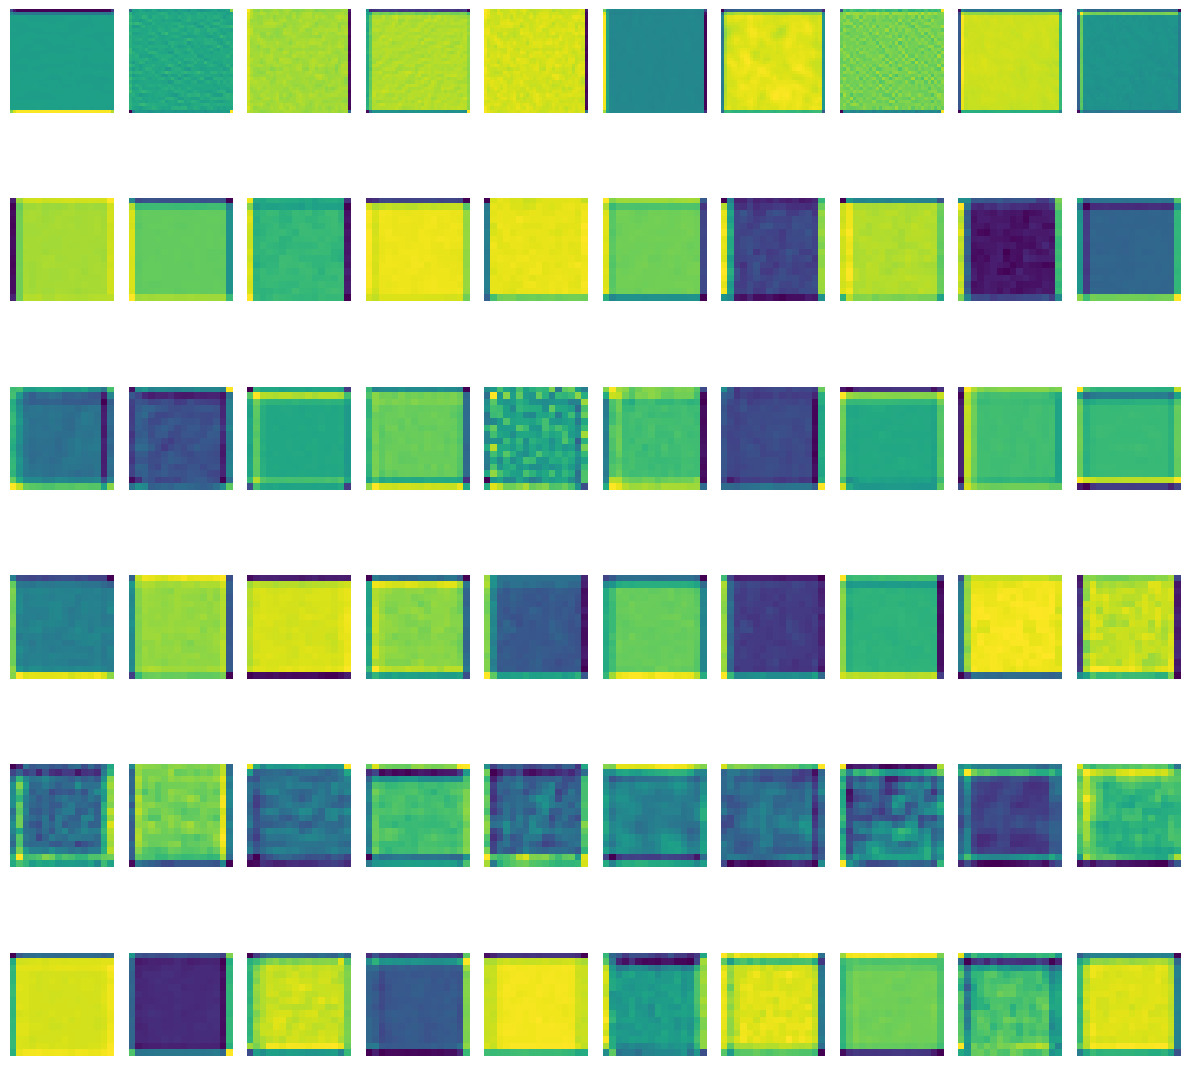

In [41]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Extract convolutional layers from DenseNet base model
conv_layers = [layer.output for layer in densenet_base.layers if isinstance(layer, tf.keras.layers.Conv2D)]

# Step 2: Create an activation model
activation_model = tf.keras.models.Model(inputs=densenet_base.input, outputs=conv_layers[:6])  # Limit to first 6 layers

# Step 3: Prepare input image (assuming x_cm contains image tensors)
sample_input = np.expand_dims(x_cm[0], axis=0)  # Add batch dimension

# Step 4: Get feature map activations
activations = activation_model.predict(sample_input)

# Step 5: Plot feature maps (limit to 6 layers, 6 feature maps each)
num_layers = min(10, len(activations))  # Max 6 layers
num_feature_maps = 10  # Max 6 channels per layer

fig, axes = plt.subplots(num_layers, num_feature_maps, figsize=(12, num_layers * 2))

for i in range(num_layers):
    activation = activations[i]
    for j in range(num_feature_maps):
        if j < activation.shape[-1]:  # Ensure channel exists
            axes[i, j].imshow(activation[0, :, :, j], cmap='viridis')
            axes[i, j].axis('off')

plt.tight_layout()
plt.show()


## Resnet50

In [42]:
from tensorflow.keras.applications import ResNet50

# Load the ResNet50 base model (excluding top layers)
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model
resnet_base.trainable = False

# Define the model
model_resnet = Sequential([
    Input(shape=input_shape),  # Explicit input layer
    resnet_base,

    # Additional Conv2D layers for a deeper feature extraction
    Conv2D(256, kernel_size=(3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),  

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax"),
])

# Compile the model
model_resnet.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model_resnet.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2, 2, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 2, 2, 256)           │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,340,746 (108.11 MB)

 Trainable params: 4,753,034 (18.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [43]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

history_resnet = model_resnet.fit(
    train,
    epochs=50,
    batch_size=batch_size,
    validation_data=val,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 49s 43ms/step - accuracy: 0.7385 - loss: 0.8759 - val_accuracy: 0.9330 - val_loss: 0.1945
Epoch 2/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 32s 33ms/step - accuracy: 0.8915 - loss: 0.3272 - val_accuracy: 0.9583 - val_loss: 0.1284
Epoch 3/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 34s 35ms/step - accuracy: 0.9235 - loss: 0.2361 - val_accuracy: 0.9552 - val_loss: 0.1227
Epoch 4/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - accuracy: 0.9389 - loss: 0.1912 - val_accuracy: 0.9650 - val_loss: 0.1032
Epoch 5/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 31s 33ms/step - accuracy: 0.9484 - loss: 0.1621 - val_accuracy: 0.9769 - val_loss: 0.0637
Epoch 6/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - accuracy: 0.9553 - loss: 0.1303 - val_accuracy: 0.9814 - val_loss: 0.0576
Epoch 7/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - accuracy: 0.9634 - loss: 0.1084 - val_accuracy: 0.9810 - val_loss: 0.0514
Epoch 8/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step - accuracy: 0.9659 - loss: 0.0989 - 

In [44]:
model_resnet.evaluate(test)

85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 1.0000 - loss: 1.4629e-04


[0.0001470846909796819, 1.0]

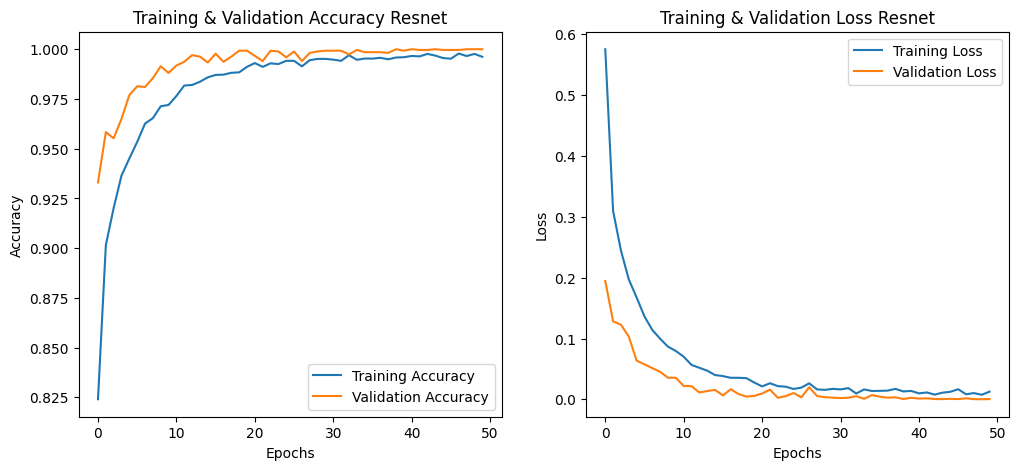

In [45]:
epochs_range = range(len(history_resnet.history['accuracy']))
# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_resnet.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy Resnet')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_resnet.history['loss'], label='Training Loss')
plt.plot(epochs_range, history_resnet.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss Resnet')


# Save in high quality
#plt.savefig("elbow_resnet.png", dpi=300, bbox_inches="tight")  # PNG format
#plt.savefig("elbow_resnet.svg", dpi=300, bbox_inches="tight")  # SVG format

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


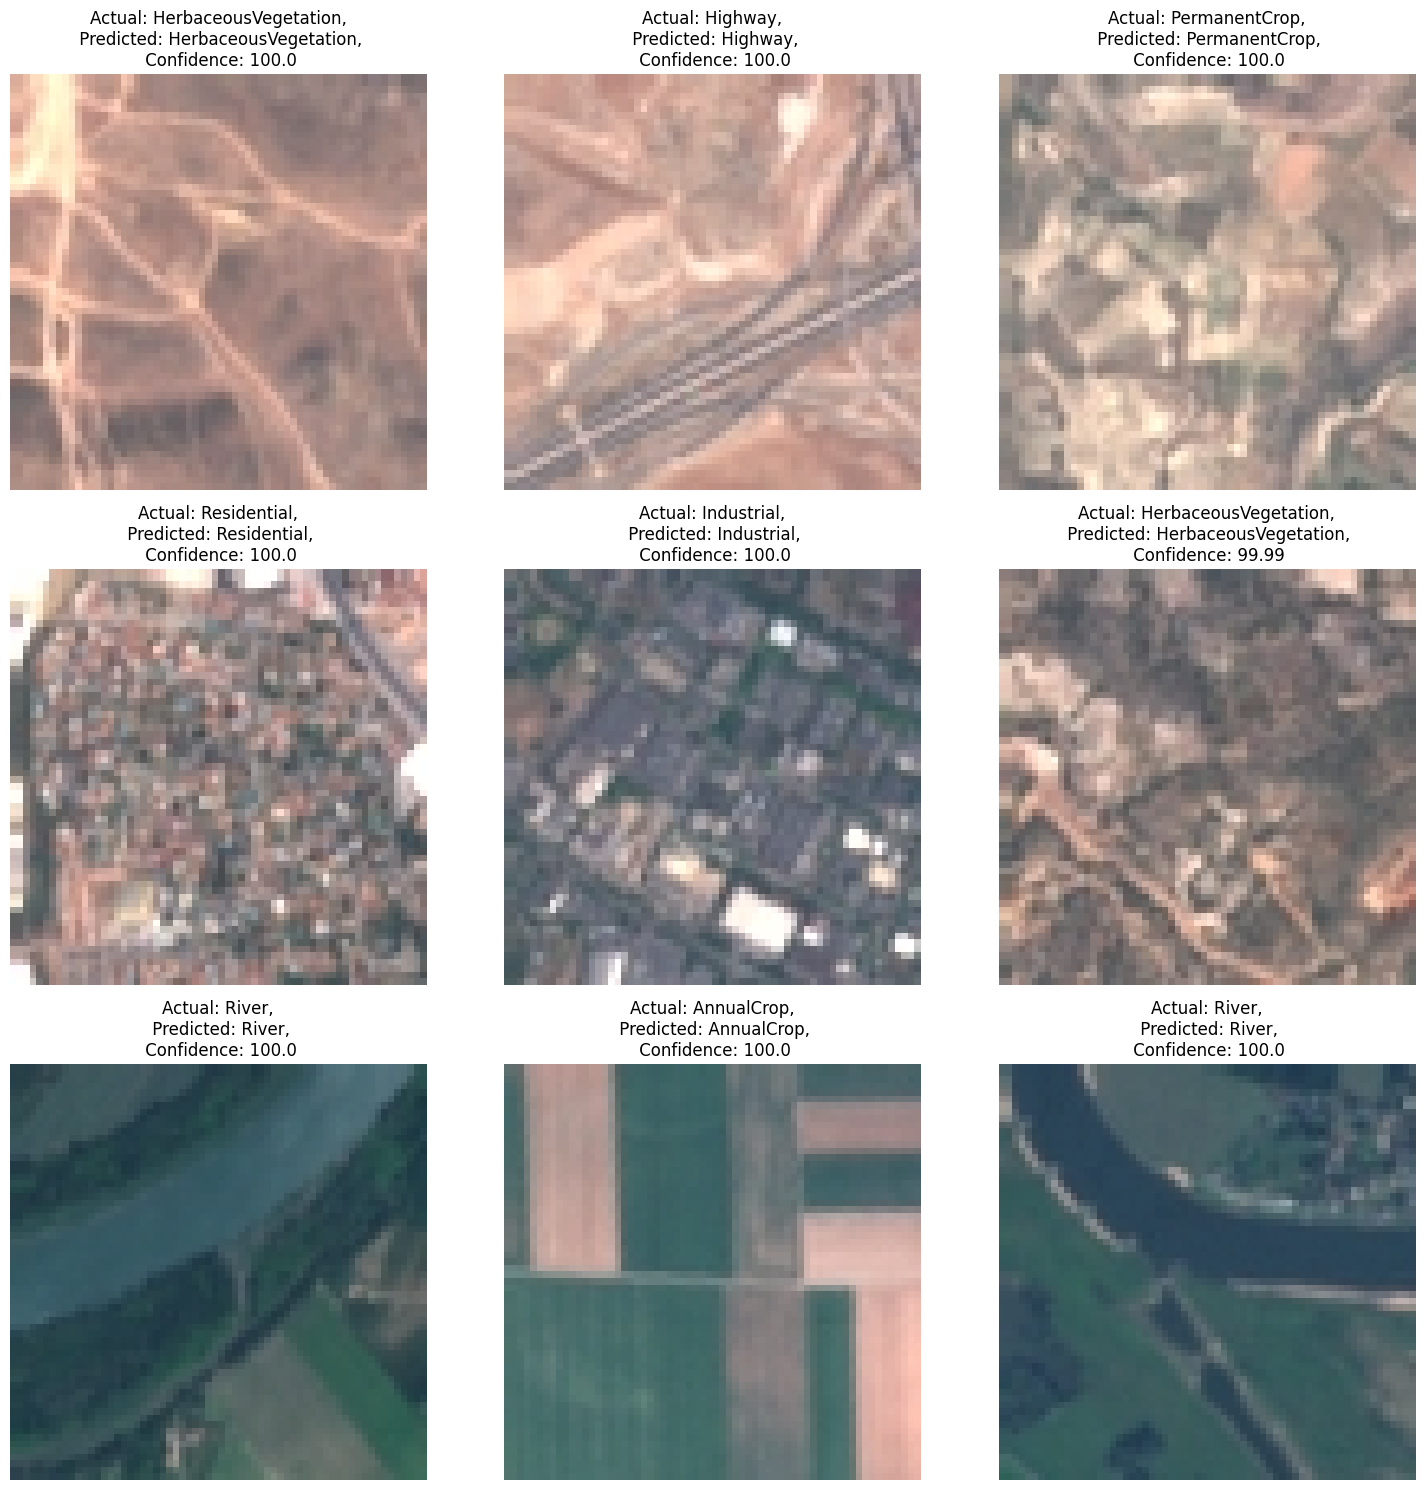

In [46]:
plt.figure(figsize=(15, 15))
for images2, labels in test.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images2[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model_resnet, images2[i].numpy(), images.class_names)
        actual_class = images.class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}")
        plt.axis("off")

plt.tight_layout()  # Ensure spacing is good

# Save in high quality
#plt.savefig("prediction_grid_resnet.png", dpi=300, bbox_inches="tight")  # PNG format
#plt.savefig("prediction_grid_resnet.svg", dpi=300, bbox_inches="tight")  # SVG format

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


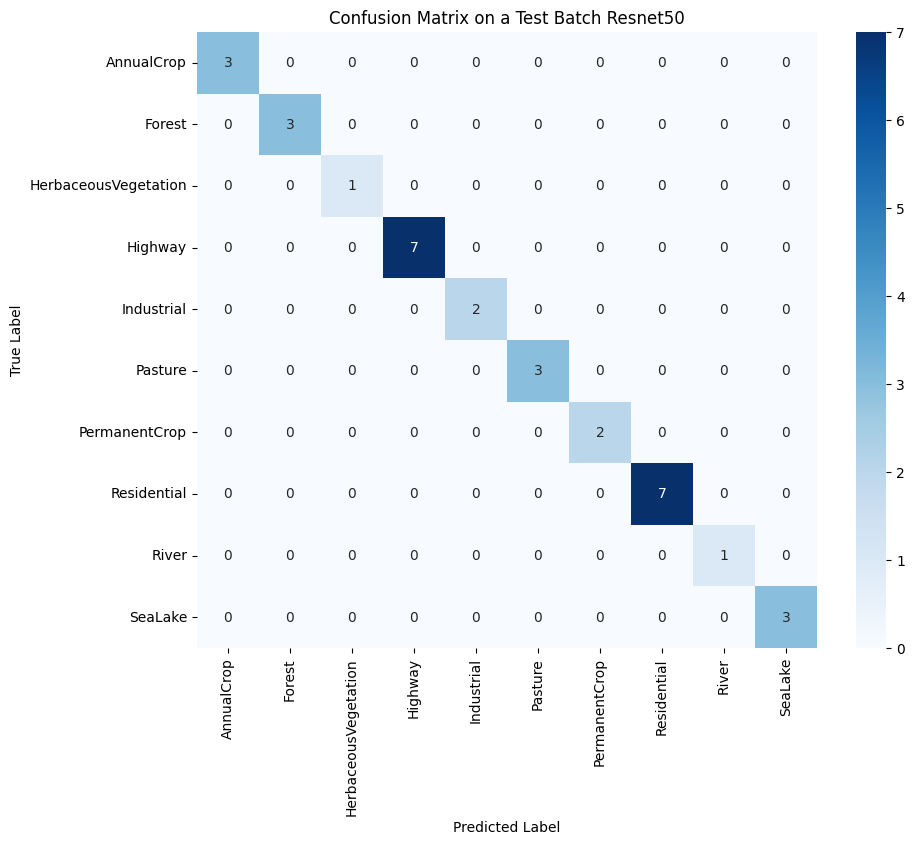

In [47]:
# Take a portion of the test set for a stable evaluation (do NOT shuffle)
cm_dataset = test.take(5)  # Take a single batch to ensure label alignment

# Extract images and labels from `cm_dataset`
x_cm, y_true = next(iter(cm_dataset))  # Extract a single batch
y_true = y_true.numpy()  # Convert TensorFlow tensor to NumPy array

# Predict on the extracted batch
y_pred_probs = model_resnet.predict(x_cm)  # Get probability scores
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
ax = plt.subplot(1, 1, 1)  # Single subplot for consistency
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=images.class_names, yticklabels=images.class_names)

plt.title("Confusion Matrix on a Test Batch Resnet50")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

#plt.savefig("confusion_matrix_resnet.png", dpi=300, bbox_inches="tight")  # PNG format (for PowerPoint, etc.)
#plt.savefig("confusion_matrix_resnet.svg", dpi=300, bbox_inches="tight")  # SVG format (for zooming without quality loss)
plt.show()


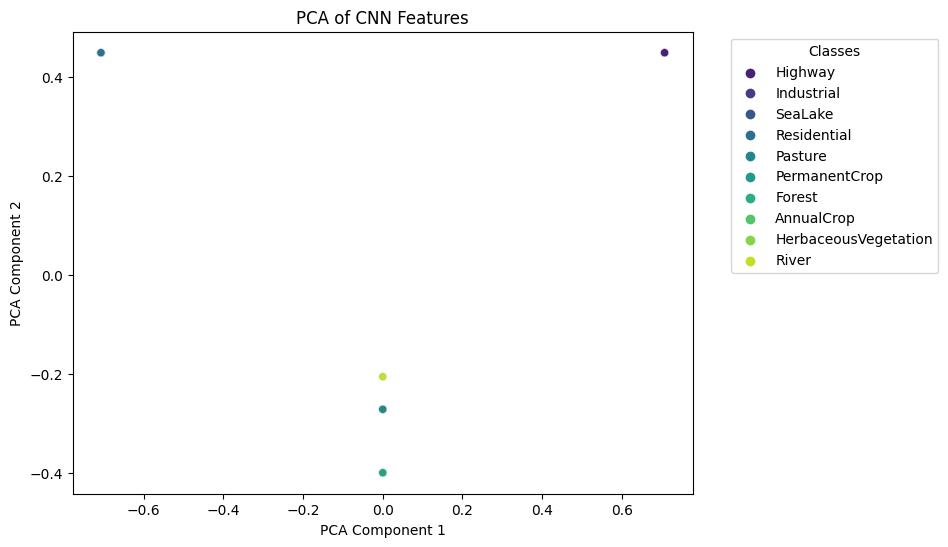

In [48]:

# PCA Visualization
# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(y_pred_probs)

# Convert y_true to class names
class_names = np.array(images.class_names)
y_labels = class_names[y_true]  # Map numerical labels to class names

# Plot PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_labels, palette='viridis', alpha=0.7)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of CNN Features')
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside
#plt.savefig("pca_cnn.png", dpi=300, bbox_inches="tight")
#plt.savefig("pca_cnn.svg", dpi=300, bbox_inches="tight")
plt.show()

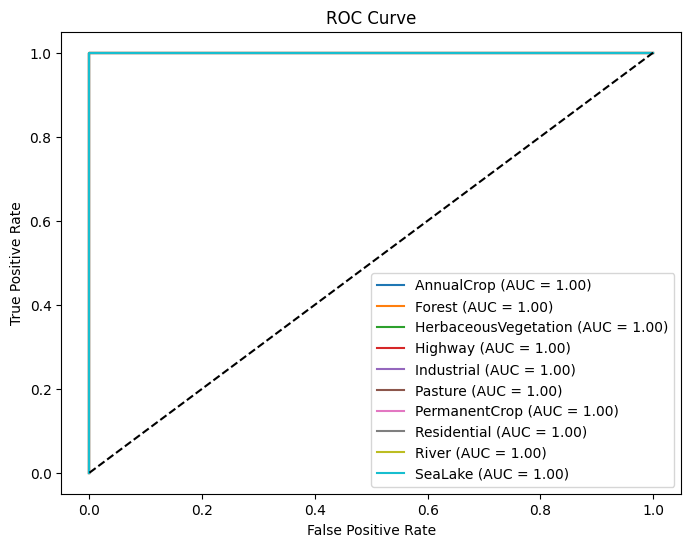

In [49]:
num_classes = len(images.class_names)
y_test_bin = label_binarize(y_true, classes=np.arange(num_classes))

plt.figure(figsize=(8, 6))
for i, class_name in enumerate(images.class_names):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
#plt.savefig("roc_vgg.png", dpi=300, bbox_inches="tight")
#plt.savefig("roc_vgg.svg", dpi=300, bbox_inches="tight")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


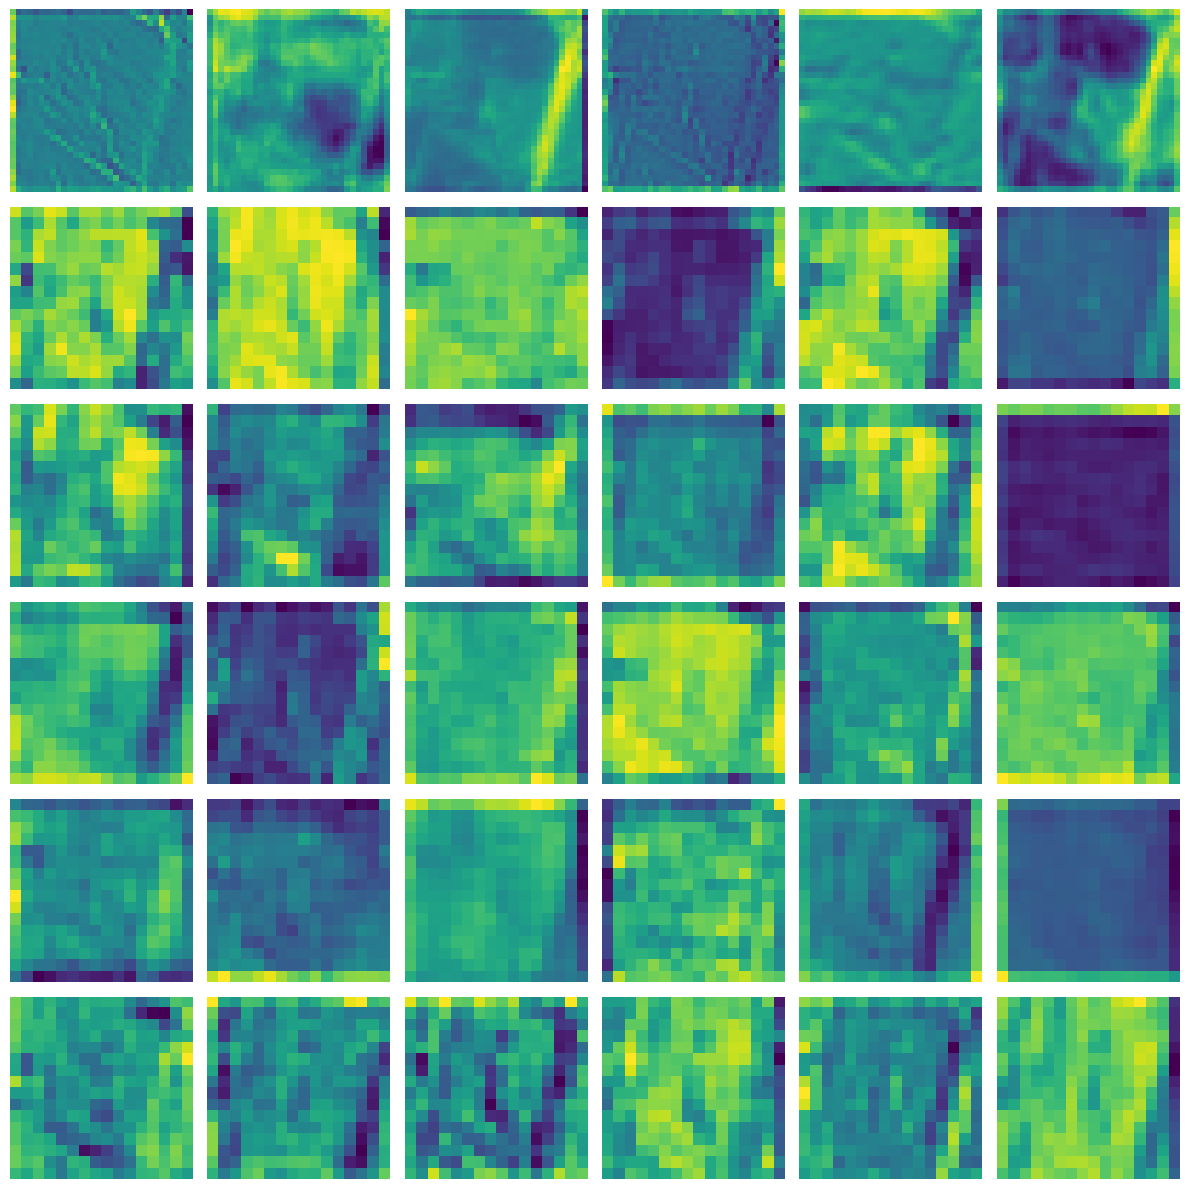

In [50]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

# Step 1: Extract convolutional layers from ResNet50 base model
conv_layers = [layer.output for layer in resnet_base.layers if isinstance(layer, tf.keras.layers.Conv2D)]

# Step 2: Create an activation model (limit to first 6 convolutional layers)
activation_model = Model(inputs=resnet_base.input, outputs=conv_layers[:6])

# Step 3: Prepare input image (assuming x_sample contains image tensors)
sample_input = np.expand_dims(x_cm[0], axis=0)  # Add batch dimension

# Step 4: Get feature map activations
activations = activation_model.predict(sample_input)

# Step 5: Plot feature maps (limit to 6 layers, 6 feature maps each)
num_layers = min(6, len(activations))  # Max 6 layers
num_feature_maps = 6  # Max 6 channels per layer

fig, axes = plt.subplots(num_layers, num_feature_maps, figsize=(12, num_layers * 2))

for i in range(num_layers):
    activation = activations[i]
    for j in range(num_feature_maps):
        if j < activation.shape[-1]:  # Ensure channel exists
            axes[i, j].imshow(activation[0, :, :, j], cmap='viridis')
            axes[i, j].axis('off')

plt.tight_layout()
plt.show()


In [51]:
# Get only numeric folder names
existing_versions = [int(i) for i in os.listdir("/kaggle/working/") if i.isdigit()]

# Determine the next version number
model_version = max(existing_versions, default=0) + 1

# Define the save path with `.keras` extension
save_path = f"/kaggle/working/{model_version}_resnet50.keras"

# Save the model
model_resnet.save(save_path)
print(f"Model saved as {save_path}")

model_vgg16 = tf.keras.models.load_model("/kaggle/working/1_resnet50.keras")

Model saved as /kaggle/working/1_resnet50.keras
